##                           Business Problem
Effective inventory and sales management are critical for optimizing
profitability in the retail and wholesale industry. Companies need to ensure
that they are not incurring losses due to inefficient pricing, poor inventory
turnover, or vendor dependency. The goal of this analysis is to:

-  Identify underperforming brands that require promotional or pricing
adjustments.
-  Determine top vendors contributing to sales and gross profit.
- Analyze the impact of bulk purchasing on unit costs.
- Assess inventory turnover to reduce holding costs and improve
efficiency.
- Investigate the profitability variance between high-performing and
low-performing vendors.

In [5]:
import pandas as pd 
import os
from sqlalchemy import create_engine

In [6]:
import os
os.makedirs("data", exist_ok=True)   # ensures folder exists

engine = create_engine("sqlite:///data/mydb.db")


In [7]:
for file in os.listdir('data'):
    if '.csv' in file:
        df=pd.read_csv('data/'+file)
        print(df.shape)
      
        

(206529, 9)
(224489, 9)
(2372474, 16)
(12261, 9)
(12825363, 14)
(5543, 10)


In [8]:
def  ingest_db(df,table_name,engine):
    df.to_sql(table_name,con=engine,if_exists='replace',index=False)

In [9]:
import os

for file in os.listdir('data'):
    print(file, os.path.getsize('data/' + file) / (1024*1024), "MB")


.ipynb_checkpoints 0.0 MB
begin_inventory.csv 16.63944149017334 MB
end_inventory.csv 18.104559898376465 MB
purchases.csv 344.8250789642334 MB
purchase_prices.csv 0.9989194869995117 MB
sales.csv 1522.764310836792 MB
vendor_invoice.csv 0.48630428314208984 MB


In [10]:
import os
import pandas as pd
from sqlalchemy import create_engine, text

# -----------------------------
# 1. Create DB folder if needed
# -----------------------------
os.makedirs("database", exist_ok=True)

# -----------------------------
# 2. Create SQLite Database
# -----------------------------
db_path = os.getcwd() + "/database/inventory.db"
engine = create_engine(f"sqlite:///{db_path}", echo=False)

# -----------------------------
# 3. Optimize SQLite for speed
#    (SQLAlchemy 2.0 compatible)
# -----------------------------
with engine.connect() as conn:
    conn.execute(text("PRAGMA journal_mode=WAL;"))
    conn.execute(text("PRAGMA synchronous=OFF;"))
    conn.execute(text("PRAGMA temp_store=MEMORY;"))
    conn.execute(text("PRAGMA locking_mode=EXCLUSIVE;"))
    conn.commit()

print("Database created at:", db_path)


# ----------------------------------------------------
# 4. Function to choose chunk size based on file size
# ----------------------------------------------------
def get_chunk_size(file):
    if "sales" in file.lower():
        return 20000         # Very large file (1.5 GB)
    elif "purchases" in file.lower():
        return 50000         # Large file (345 MB)
    else:
        return 50000         # Small files


# ----------------------------------------------------
# 5. Safe ingestion function (handles large files)
# ----------------------------------------------------
def ingest_db_in_chunks(path, table, engine):
    chunksize = get_chunk_size(path)
    print(f"\n🚀 Starting insertion: {table} with chunksize={chunksize}")

    try:
        for chunk in pd.read_csv(path, chunksize=chunksize, low_memory=False):
            chunk.to_sql(table, engine, if_exists="append", index=False)
        print(f"✅ Completed table: {table}")

    except Exception as e:
        print(f"❌ Error inserting {table}: {e}")


# ----------------------------------------------------
# 6. Loop through CSV files and insert each
# ----------------------------------------------------
folder = "data"

for file in os.listdir(folder):
    if file.endswith(".csv"):
        table_name = file[:-4]
        file_path = os.path.join(folder, file)
        ingest_db_in_chunks(file_path, table_name, engine)

print("\n🎉 ALL TABLES INSERTED SUCCESSFULLY!")




Database created at: C:\Users\jeeva\Downloads\data/database/inventory.db

🚀 Starting insertion: begin_inventory with chunksize=50000
✅ Completed table: begin_inventory

🚀 Starting insertion: end_inventory with chunksize=50000
✅ Completed table: end_inventory

🚀 Starting insertion: purchases with chunksize=50000
✅ Completed table: purchases

🚀 Starting insertion: purchase_prices with chunksize=50000
✅ Completed table: purchase_prices

🚀 Starting insertion: sales with chunksize=20000
✅ Completed table: sales

🚀 Starting insertion: vendor_invoice with chunksize=50000
✅ Completed table: vendor_invoice

🎉 ALL TABLES INSERTED SUCCESSFULLY!


## exploraroty data analysis

In [1]:
import pandas as pd
import sqlite3

In [2]:
conn=sqlite3.connect('inventory.db')

In [3]:
tables=pd.read_sql_query("select name from sqlite_master where type='table'",conn)
tables

,name
0,begin_inventory
1,end_inventory
2,purchases
3,purchase_prices
4,sales
5,vendor_invoice
6,vendor_sales_summary
7,vendor_sales
8,Vendor_sales_


In [4]:
for table in tables['name']:
    print('-'*50,f'{table}','-'*50)
    print('count of records:',pd.read_sql(f'select count(*) as count from {table}',conn)['count'].values[0])
    display(pd.read_sql(f'select* from {table} limit 5',conn))

-------------------------------------------------- begin_inventory --------------------------------------------------
count of records: 206529


,InventoryId,Store,City,Brand,Description,Size,onHand,Price,startDate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,8,12.99,2024-01-01
1,1_HARDERSFIELD_60,1,HARDERSFIELD,60,Canadian Club 1858 VAP,750mL,7,10.99,2024-01-01
2,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,6,36.99,2024-01-01
3,1_HARDERSFIELD_63,1,HARDERSFIELD,63,Herradura Reposado Tequila,750mL,3,38.99,2024-01-01
4,1_HARDERSFIELD_72,1,HARDERSFIELD,72,No. 3 London Dry Gin,750mL,6,34.99,2024-01-01


-------------------------------------------------- end_inventory --------------------------------------------------
count of records: 224489


,InventoryId,Store,City,Brand,Description,Size,onHand,Price,endDate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,11,12.99,2024-12-31
1,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,7,36.99,2024-12-31
2,1_HARDERSFIELD_63,1,HARDERSFIELD,63,Herradura Reposado Tequila,750mL,7,38.99,2024-12-31
3,1_HARDERSFIELD_72,1,HARDERSFIELD,72,No. 3 London Dry Gin,750mL,4,34.99,2024-12-31
4,1_HARDERSFIELD_75,1,HARDERSFIELD,75,Three Olives Tomato Vodka,750mL,7,14.99,2024-12-31


-------------------------------------------------- purchases --------------------------------------------------
count of records: 2372474


,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification
0,69_MOUNTMEND_8412,69,8412,Tequila Ocho Plata Fresno,750mL,105,ALTAMAR BRANDS LLC,8124,2023-12-21,2024-01-02,2024-01-04,2024-02-16,35.71,6,214.26,1
1,30_CULCHETH_5255,30,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-01,2024-01-07,2024-02-21,9.35,4,37.40,1
2,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-02,2024-01-07,2024-02-21,9.41,5,47.05,1
3,1_HARDERSFIELD_5255,1,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-01,2024-01-07,2024-02-21,9.35,6,56.10,1
4,76_DONCASTER_2034,76,2034,Glendalough Double Barrel,750mL,388,ATLANTIC IMPORTING COMPANY,8169,2023-12-24,2024-01-02,2024-01-09,2024-02-16,21.32,5,106.60,1


-------------------------------------------------- purchase_prices --------------------------------------------------
count of records: 12261


,Brand,Description,Price,Size,Volume,Classification,PurchasePrice,VendorNumber,VendorName
0,58,Gekkeikan Black & Gold Sake,12.99,750mL,750,1,9.28,8320,SHAW ROSS INT L IMP LTD
1,62,Herradura Silver Tequila,36.99,750mL,750,1,28.67,1128,BROWN-FORMAN CORP
2,63,Herradura Reposado Tequila,38.99,750mL,750,1,30.46,1128,BROWN-FORMAN CORP
3,72,No. 3 London Dry Gin,34.99,750mL,750,1,26.11,9165,ULTRA BEVERAGE COMPANY LLP
4,75,Three Olives Tomato Vodka,14.99,750mL,750,1,10.94,7245,PROXIMO SPIRITS INC.


-------------------------------------------------- sales --------------------------------------------------
count of records: 12825363


,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName
0,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2024-01-01,750.0,1,0.79,12546,JIM BEAM BRANDS COMPANY
1,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,2,32.98,16.49,2024-01-02,750.0,1,1.57,12546,JIM BEAM BRANDS COMPANY
2,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2024-01-03,750.0,1,0.79,12546,JIM BEAM BRANDS COMPANY
3,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,14.49,14.49,2024-01-08,750.0,1,0.79,12546,JIM BEAM BRANDS COMPANY
4,1_HARDERSFIELD_1005,1,1005,Maker's Mark Combo Pack,375mL 2 Pk,2,69.98,34.99,2024-01-09,375.0,1,0.79,12546,JIM BEAM BRANDS COMPANY


-------------------------------------------------- vendor_invoice --------------------------------------------------
count of records: 11086


,VendorNumber,VendorName,InvoiceDate,PONumber,PODate,PayDate,Quantity,Dollars,Freight,Approval
0,105,ALTAMAR BRANDS LLC,2024-01-04,8124,2023-12-21,2024-02-16,6,214.26,3.47,None
1,4466,AMERICAN VINTAGE BEVERAGE,2024-01-07,8137,2023-12-22,2024-02-21,15,140.55,8.57,None
2,388,ATLANTIC IMPORTING COMPANY,2024-01-09,8169,2023-12-24,2024-02-16,5,106.60,4.61,None
3,480,BACARDI USA INC,2024-01-12,8106,2023-12-20,2024-02-05,10100,137483.78,2935.20,None
4,516,BANFI PRODUCTS CORP,2024-01-07,8170,2023-12-24,2024-02-12,1935,15527.25,429.20,None


-------------------------------------------------- vendor_sales_summary --------------------------------------------------
count of records: 10692


,VendorNumber,VendorName,Brand,Volume,ActualPrice,PurchasePrice,TotalPurchaseQuantity,TotalPurchaseDollars,FreightCost,TotalSalesDollars,TotalSalesQuantity,TotalExciseTax,GrossProfit,ProfitMargin,StockTurnover,SalestoPurchaseRatio
0,1128,BROWN-FORMAN CORP,1233,1750.0,36.99,26.27,145080,3811251.60,137203.36,5101919.51,142049.0,260999.20,1290667.91,25.297693,0.979108,1.338647
1,4425,MARTIGNETTI COMPANIES,3405,1750.0,28.99,23.19,164038,3804041.22,289858.48,4819073.49,160247.0,294438.66,1015032.27,21.062810,0.976890,1.266830
2,17035,PERNOD RICARD USA,8068,1750.0,24.99,18.24,187407,3418303.68,247560.44,4538120.60,187140.0,343854.07,1119816.92,24.675786,0.998575,1.327594
3,3960,DIAGEO NORTH AMERICA INC,4261,1750.0,22.99,16.17,201682,3261197.94,514064.14,4475972.88,200412.0,368242.80,1214774.94,27.139908,0.993703,1.372493
4,3960,DIAGEO NORTH AMERICA INC,3545,1750.0,29.99,21.89,138109,3023206.01,514064.14,4223107.62,135838.0,249587.83,1199901.61,28.412764,0.983556,1.396897


-------------------------------------------------- vendor_sales --------------------------------------------------
count of records: 10692


,VendorNumber,VendorName,Brand,Volume,ActualPrice,PurchasePrice,TotalPurchaseQuantity,TotalPurchaseDollars,FreightCost,TotalSalesDollars,TotalSalesQuantity,TotalExciseTax,GrossProfit,ProfitMargin,StockTurnover,SalestoPurchaseRatio
0,1128,BROWN-FORMAN CORP,1233,1750.0,36.99,26.27,145080,3811251.60,137203.36,5101919.51,142049.0,260999.20,1290667.91,25.297693,0.979108,1.338647
1,4425,MARTIGNETTI COMPANIES,3405,1750.0,28.99,23.19,164038,3804041.22,289858.48,4819073.49,160247.0,294438.66,1015032.27,21.062810,0.976890,1.266830
2,17035,PERNOD RICARD USA,8068,1750.0,24.99,18.24,187407,3418303.68,247560.44,4538120.60,187140.0,343854.07,1119816.92,24.675786,0.998575,1.327594
3,3960,DIAGEO NORTH AMERICA INC,4261,1750.0,22.99,16.17,201682,3261197.94,514064.14,4475972.88,200412.0,368242.80,1214774.94,27.139908,0.993703,1.372493
4,3960,DIAGEO NORTH AMERICA INC,3545,1750.0,29.99,21.89,138109,3023206.01,514064.14,4223107.62,135838.0,249587.83,1199901.61,28.412764,0.983556,1.396897


-------------------------------------------------- Vendor_sales_ --------------------------------------------------
count of records: 10692


,VendorNumber,VendorName,Brand,Description,Volume,ActualPrice,PurchasePrice,TotalPurchaseQuantity,TotalPurchaseDollars,FreightCost,TotalSalesDollars,TotalSalesQuantity,TotalExciseTax,GrossProfit,ProfitMargin,StockTurnover,SalestoPurchaseRatio
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,1750.0,36.99,26.27,145080,3811251.60,137203.36,5101919.51,142049.0,260999.20,1290667.91,25.297693,0.979108,1.338647
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,1750.0,28.99,23.19,164038,3804041.22,289858.48,4819073.49,160247.0,294438.66,1015032.27,21.062810,0.976890,1.266830
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,1750.0,24.99,18.24,187407,3418303.68,247560.44,4538120.60,187140.0,343854.07,1119816.92,24.675786,0.998575,1.327594
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,1750.0,22.99,16.17,201682,3261197.94,514064.14,4475972.88,200412.0,368242.80,1214774.94,27.139908,0.993703,1.372493
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,1750.0,29.99,21.89,138109,3023206.01,514064.14,4223107.62,135838.0,249587.83,1199901.61,28.412764,0.983556,1.396897


In [5]:
purchases=pd.read_sql_query('select * from purchases where VendorNumber=4466',conn)
purchases

,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification
0,30_CULCHETH_5255,30,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-01,2024-01-07,2024-02-21,9.35,4,37.40,1
1,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-02,2024-01-07,2024-02-21,9.41,5,47.05,1
2,1_HARDERSFIELD_5255,1,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-01,2024-01-07,2024-02-21,9.35,6,56.10,1
3,38_GOULCREST_5215,38,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8207,2023-12-27,2024-01-07,2024-01-19,2024-02-26,9.41,6,56.46,1
4,59_CLAETHORPES_5215,59,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8207,2023-12-27,2024-01-05,2024-01-19,2024-02-26,9.41,6,56.46,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,81_PEMBROKE_5215,81,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,13595,2024-12-20,2024-12-29,2025-01-04,2025-02-10,9.41,6,56.46,1
2188,62_KILMARNOCK_5255,62,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,13595,2024-12-20,2024-12-28,2025-01-04,2025-02-10,9.35,5,46.75,1
2189,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,13595,2024-12-20,2024-12-28,2025-01-04,2025-02-10,9.41,5,47.05,1
2190,6_GOULCREST_5215,6,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,13595,2024-12-20,2024-12-31,2025-01-04,2025-02-10,9.41,6,56.46,1


In [6]:
purchase_prices=pd.read_sql_query('select * from purchase_prices where VendorNumber=4466',conn)
purchase_prices

,Brand,Description,Price,Size,Volume,Classification,PurchasePrice,VendorNumber,VendorName
0,5215,TGI Fridays Long Island Iced,12.99,1750mL,1750,1,9.41,4466,AMERICAN VINTAGE BEVERAGE
1,5255,TGI Fridays Ultimte Mudslide,12.99,1750mL,1750,1,9.35,4466,AMERICAN VINTAGE BEVERAGE
2,3140,TGI Fridays Orange Dream,14.99,1750mL,1750,1,11.19,4466,AMERICAN VINTAGE BEVERAGE


In [7]:
vendor_invoice=pd.read_sql_query('select * from vendor_invoice where VendorNumber=4466',conn)
vendor_invoice

,VendorNumber,VendorName,InvoiceDate,PONumber,PODate,PayDate,Quantity,Dollars,Freight,Approval
0,4466,AMERICAN VINTAGE BEVERAGE,2024-01-07,8137,2023-12-22,2024-02-21,15,140.55,8.57,None
1,4466,AMERICAN VINTAGE BEVERAGE,2024-01-19,8207,2023-12-27,2024-02-26,335,3142.33,16.97,None
2,4466,AMERICAN VINTAGE BEVERAGE,2024-01-18,8307,2024-01-03,2024-02-18,41,383.35,1.99,None
3,4466,AMERICAN VINTAGE BEVERAGE,2024-01-27,8469,2024-01-14,2024-03-11,72,673.20,3.30,None
4,4466,AMERICAN VINTAGE BEVERAGE,2024-02-04,8532,2024-01-19,2024-03-15,79,740.21,3.48,None
...,...,...,...,...,...,...,...,...,...,...
105,4466,AMERICAN VINTAGE BEVERAGE,2024-12-06,13134,2024-11-20,2025-01-18,305,3018.89,15.70,None
106,4466,AMERICAN VINTAGE BEVERAGE,2024-12-16,13254,2024-11-28,2025-01-13,262,2530.36,11.39,None
107,4466,AMERICAN VINTAGE BEVERAGE,2024-12-26,13432,2024-12-09,2025-01-27,231,2263.43,11.32,None
108,4466,AMERICAN VINTAGE BEVERAGE,2024-12-30,13483,2024-12-13,2025-02-11,221,2178.27,11.33,None


In [8]:
sales=pd.read_sql_query('select * from sales where VendorNo=4466',conn)
sales

,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName
0,1_HARDERSFIELD_5215,1,5215,TGI Fridays Long Island Iced,1.75L,1,12.99,12.99,2024-01-09,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE
1,1_HARDERSFIELD_5215,1,5215,TGI Fridays Long Island Iced,1.75L,1,12.99,12.99,2024-01-12,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE
2,1_HARDERSFIELD_5215,1,5215,TGI Fridays Long Island Iced,1.75L,1,12.99,12.99,2024-01-15,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE
3,1_HARDERSFIELD_5215,1,5215,TGI Fridays Long Island Iced,1.75L,1,12.99,12.99,2024-01-21,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE
4,1_HARDERSFIELD_5215,1,5215,TGI Fridays Long Island Iced,1.75L,1,12.99,12.99,2024-01-23,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9448,9_BLACKPOOL_5215,9,5215,TGI Fridays Long Island Iced,1.75L,1,12.99,12.99,2024-12-21,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE
9449,9_BLACKPOOL_5255,9,5255,TGI Fridays Ultimte Mudslide,1.75L,1,12.99,12.99,2024-12-02,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE
9450,9_BLACKPOOL_5255,9,5255,TGI Fridays Ultimte Mudslide,1.75L,1,12.99,12.99,2024-12-09,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE
9451,9_BLACKPOOL_5255,9,5255,TGI Fridays Ultimte Mudslide,1.75L,1,12.99,12.99,2024-12-23,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE


In [9]:
purchases.groupby(['Brand','PurchasePrice'])[['Quantity','Dollars']].sum()

,,Quantity,Dollars
Brand,PurchasePrice,,
3140,11.19,4640,51921.60
5215,9.41,4923,46325.43
5255,9.35,6215,58110.25


In [10]:
sales.groupby('Brand')[['SalesDollars','SalesPrice','SalesQuantity']].sum()

,SalesDollars,SalesPrice,SalesQuantity
Brand,,,
3140,50531.10,30071.85,3890
5215,60416.49,41542.02,4651
5255,79187.04,51180.60,6096


- The purchases table contains actual purchase data, including the date of purchase, products (brands) purchased by vendors, the amount paid (in dollars), and the quantity purchased.
- The purchase price column is derived from the purchase_prices table, which provides product-wise actual and purchase prices. The combination of vendor and brand is unique in this table.
- The vendor_invoice table aggregates data from the purchases table, summarizing quantity and dollar amounts, along with an additional column for freight.
This table maintains uniqueness based on vendor and PO number.
- The sales table captures actual sales transactions, detailing the brands purchased by vendors, the quantity sold, the selling price, and the revenue earned.

***
    
As the data that we need for analysis is distributed in different tables, we need to create a summary table containing:
- purchase transactions made by vendors
- sales transaction data
- freight costs for each vendor
- actual product prices from vendors

In [11]:
freight_summary= pd.read_sql_query('select VendorNumber,sum(Freight) as FreightCost from vendor_invoice group by VendorNumber',conn)

In [12]:
freight_summary

,VendorNumber,FreightCost
0,2,54.16
1,54,0.96
2,60,735.04
3,105,124.78
4,200,12.38
...,...,...
121,98450,1712.04
122,99166,260.18
123,172662,356.68
124,173357,405.00


In [13]:
purchases.columns

Index(['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'VendorNumber',
       'VendorName', 'PONumber', 'PODate', 'ReceivingDate', 'InvoiceDate',
       'PayDate', 'PurchasePrice', 'Quantity', 'Dollars', 'Classification'],
      dtype='object')

In [14]:
purchase_prices.columns

Index(['Brand', 'Description', 'Price', 'Size', 'Volume', 'Classification',
       'PurchasePrice', 'VendorNumber', 'VendorName'],
      dtype='object')

In [15]:
pd.read_sql_query("""select p.VendorNumber,p.VendorName,p.Brand,p.PurchasePrice,
pp.Volume,pp.Price as ActualPrice,sum(p.Quantity) as TotalPurchaseQuantity,
sum(p.Dollars) as TotalPurchaseDollars 
from purchases p join purchase_prices pp using (Brand) where p.PurchasePrice>0
group by p.VendorNumber,p.VendorName,p.Brand order by TotalPurchaseDollars""",conn)

,VendorNumber,VendorName,Brand,PurchasePrice,Volume,ActualPrice,TotalPurchaseQuantity,TotalPurchaseDollars
0,7245,PROXIMO SPIRITS INC.,3065,0.71,50,0.99,1,0.71
1,3960,DIAGEO NORTH AMERICA INC,6127,1.47,200,1.99,1,1.47
2,3924,HEAVEN HILL DISTILLERIES,9123,0.74,50,0.99,2,1.48
3,8004,SAZERAC CO INC,5683,0.39,50,0.49,6,2.34
4,9815,WINE GROUP INC,8527,1.32,750,4.99,2,2.64
...,...,...,...,...,...,...,...,...
10687,3960,DIAGEO NORTH AMERICA INC,3545,21.89,1750,29.99,138109,3023206.01
10688,3960,DIAGEO NORTH AMERICA INC,4261,16.17,1750,22.99,201682,3261197.94
10689,17035,PERNOD RICARD USA,8068,18.24,1750,24.99,187407,3418303.68
10690,4425,MARTIGNETTI COMPANIES,3405,23.19,1750,28.99,164038,3804041.22


In [16]:
sales.columns

Index(['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'SalesQuantity',
       'SalesDollars', 'SalesPrice', 'SalesDate', 'Volume', 'Classification',
       'ExciseTax', 'VendorNo', 'VendorName'],
      dtype='object')

In [17]:
pd.read_sql_query(""" select
     VendorNo,Brand,sum(SalesDollars) as TotalsalesDollars,
     sum(SalesQuantity) as TotalSalesQuantity,sum(ExciseTax) as TotalExciseTax from sales
     group by VendorNo,Brand""",conn)

,VendorNo,Brand,TotalsalesDollars,TotalSalesQuantity,TotalExciseTax
0,2,90085,665.82,18,2.00
1,2,90609,599.76,24,0.52
2,60,771,704.53,47,37.01
3,60,3979,66871.69,3931,7224.06
4,105,2529,359.88,12,9.44
...,...,...,...,...,...
11267,173357,2804,6298.60,140,110.33
11268,173357,3666,8996.40,360,141.19
11269,173357,3848,185.94,6,4.71
11270,173357,3909,24540.18,982,773.87


In [18]:
final_table = pd.read_sql_query("""
WITH purchase_summary AS (
    SELECT 
        p.VendorNumber,
        p.VendorName,
        p.Brand,
        pp.Description,         -- ⭐ ADDED THIS
        pp.Volume,
        pp.Price AS ActualPrice,
        p.PurchasePrice,
        SUM(p.Quantity) AS TotalPurchaseQuantity,
        SUM(p.Dollars) AS TotalPurchaseDollars
    FROM purchases p
    JOIN purchase_prices pp USING (Brand)
    WHERE p.PurchasePrice > 0
    GROUP BY 
        p.VendorNumber, 
        p.VendorName, 
        p.Brand,
        pp.Description,         -- ⭐ MUST be in GROUP BY
        pp.Volume, 
        pp.Price, 
        p.PurchasePrice
),

freight_summary AS (
    SELECT VendorNumber, SUM(Freight) AS FreightCost
    FROM vendor_invoice
    GROUP BY VendorNumber
),

sales_summary AS (
    SELECT
        VendorNo AS VendorNumber,
        Brand,
        SUM(SalesDollars) AS TotalSalesDollars,
        SUM(SalesQuantity) AS TotalSalesQuantity,
        SUM(ExciseTax) AS TotalExciseTax
    FROM sales
    GROUP BY VendorNo, Brand
)

SELECT 
    ps.*,
    fs.FreightCost,
    ss.TotalSalesDollars,
    ss.TotalSalesQuantity,
    ss.TotalExciseTax
FROM purchase_summary ps
LEFT JOIN freight_summary fs 
       ON ps.VendorNumber = fs.VendorNumber
LEFT JOIN sales_summary ss 
       ON ps.VendorNumber = ss.VendorNumber 
      AND ps.Brand = ss.Brand
ORDER BY ps.TotalPurchaseDollars DESC;
""", conn)




In [19]:
final_table

,VendorNumber,VendorName,Brand,Description,Volume,ActualPrice,PurchasePrice,TotalPurchaseQuantity,TotalPurchaseDollars,FreightCost,TotalSalesDollars,TotalSalesQuantity,TotalExciseTax
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,1750,36.99,26.27,145080,3811251.60,137203.36,5101919.51,142049.0,260999.20
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,1750,28.99,23.19,164038,3804041.22,289858.48,4819073.49,160247.0,294438.66
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,1750,24.99,18.24,187407,3418303.68,247560.44,4538120.60,187140.0,343854.07
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,1750,22.99,16.17,201682,3261197.94,514064.14,4475972.88,200412.0,368242.80
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,1750,29.99,21.89,138109,3023206.01,514064.14,4223107.62,135838.0,249587.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,9815,WINE GROUP INC,8527,Concannon Glen Ellen Wh Zin,750,4.99,1.32,2,2.64,54200.82,15.95,5.0,0.55
10688,8004,SAZERAC CO INC,5683,Dr McGillicuddy's Apple Pie,50,0.49,0.39,6,2.34,100587.24,65.66,134.0,7.04
10689,3924,HEAVEN HILL DISTILLERIES,9123,Deep Eddy Vodka,50,0.99,0.74,2,1.48,28139.74,1.98,2.0,0.10
10690,3960,DIAGEO NORTH AMERICA INC,6127,The Club Strawbry Margarita,200,1.99,1.47,1,1.47,514064.14,143.28,72.0,15.12


This query generates a vendor-wise sales and purchase summary, which is valuable for:
Performance Optimization:
- The query involves heavy joins and aggregations on large datasets like sales and purchases.
- Storing the pre-aggregated results avoids repeated expensive computations.
- Helps in analyzing sales, purchases, and pricing for different vendors and brands.
- Future Benefits of Storing this data for faster Dashboarding & Reporting.
- Instead of running expensive queries eachtime, dashboards can fetch data quickly from vendor_sales_summary.

In [20]:
final_table.dtypes

VendorNumber               int64
VendorName                object
Brand                      int64
Description               object
Volume                    object
ActualPrice              float64
PurchasePrice            float64
TotalPurchaseQuantity      int64
TotalPurchaseDollars     float64
FreightCost              float64
TotalSalesDollars        float64
TotalSalesQuantity       float64
TotalExciseTax           float64
dtype: object

In [21]:
final_table.isnull().sum()

VendorNumber               0
VendorName                 0
Brand                      0
Description                0
Volume                     0
ActualPrice                0
PurchasePrice              0
TotalPurchaseQuantity      0
TotalPurchaseDollars       0
FreightCost                0
TotalSalesDollars        178
TotalSalesQuantity       178
TotalExciseTax           178
dtype: int64

In [22]:
final_table['VendorName'].unique()

array(['BROWN-FORMAN CORP          ', 'MARTIGNETTI COMPANIES',
       'PERNOD RICARD USA          ', 'DIAGEO NORTH AMERICA INC   ',
       'BACARDI USA INC            ', 'JIM BEAM BRANDS COMPANY    ',
       'MAJESTIC FINE WINES        ', 'ULTRA BEVERAGE COMPANY LLP ',
       'STOLI GROUP,(USA) LLC      ', 'PROXIMO SPIRITS INC.       ',
       'MOET HENNESSY USA INC      ', 'CAMPARI AMERICA            ',
       'SAZERAC CO INC             ', 'CONSTELLATION BRANDS INC   ',
       'M S WALKER INC             ', 'SAZERAC NORTH AMERICA INC. ',
       'PALM BAY INTERNATIONAL INC ', 'REMY COINTREAU USA INC     ',
       'SIDNEY FRANK IMPORTING CO  ', 'E & J GALLO WINERY         ',
       'WILLIAM GRANT & SONS INC   ', 'HEAVEN HILL DISTILLERIES   ',
       'DISARONNO INTERNATIONAL LLC', 'EDRINGTON AMERICAS         ',
       'CASTLE BRANDS CORP.        ', 'SOUTHERN WINE & SPIRITS NE ',
       'STE MICHELLE WINE ESTATES  ', 'TRINCHERO FAMILY ESTATES   ',
       'MHW LTD                    ', 'W

In [23]:
final_table['Volume']=final_table['Volume'].astype('float64')

In [24]:
final_table.fillna(0,inplace=True)

In [25]:
final_table['VendorName']=final_table['VendorName'].str.strip()

In [26]:
final_table['VendorName'].unique()

array(['BROWN-FORMAN CORP', 'MARTIGNETTI COMPANIES', 'PERNOD RICARD USA',
       'DIAGEO NORTH AMERICA INC', 'BACARDI USA INC',
       'JIM BEAM BRANDS COMPANY', 'MAJESTIC FINE WINES',
       'ULTRA BEVERAGE COMPANY LLP', 'STOLI GROUP,(USA) LLC',
       'PROXIMO SPIRITS INC.', 'MOET HENNESSY USA INC', 'CAMPARI AMERICA',
       'SAZERAC CO INC', 'CONSTELLATION BRANDS INC', 'M S WALKER INC',
       'SAZERAC NORTH AMERICA INC.', 'PALM BAY INTERNATIONAL INC',
       'REMY COINTREAU USA INC', 'SIDNEY FRANK IMPORTING CO',
       'E & J GALLO WINERY', 'WILLIAM GRANT & SONS INC',
       'HEAVEN HILL DISTILLERIES', 'DISARONNO INTERNATIONAL LLC',
       'EDRINGTON AMERICAS', 'CASTLE BRANDS CORP.',
       'SOUTHERN WINE & SPIRITS NE', 'STE MICHELLE WINE ESTATES',
       'TRINCHERO FAMILY ESTATES', 'MHW LTD', 'WINE GROUP INC',
       'PERFECTA WINES', 'LUXCO INC', 'TREASURY WINE ESTATES',
       'DIAGEO CHATEAU ESTATE WINES', 'SHAW ROSS INT L IMP LTD',
       'PINE STATE TRADING CO', 'PHILLIPS PRO

In [27]:
final_table.isnull().sum()

VendorNumber             0
VendorName               0
Brand                    0
Description              0
Volume                   0
ActualPrice              0
PurchasePrice            0
TotalPurchaseQuantity    0
TotalPurchaseDollars     0
FreightCost              0
TotalSalesDollars        0
TotalSalesQuantity       0
TotalExciseTax           0
dtype: int64

In [28]:
final_table.dtypes

VendorNumber               int64
VendorName                object
Brand                      int64
Description               object
Volume                   float64
ActualPrice              float64
PurchasePrice            float64
TotalPurchaseQuantity      int64
TotalPurchaseDollars     float64
FreightCost              float64
TotalSalesDollars        float64
TotalSalesQuantity       float64
TotalExciseTax           float64
dtype: object

In [29]:
final_table['GrossProfit']=final_table['TotalSalesDollars']-final_table['TotalPurchaseDollars']

In [30]:
final_table['ProfitMargin']=(final_table['GrossProfit']/final_table['TotalSalesDollars'])*100


In [31]:
final_table['StockTurnover']=final_table['TotalSalesQuantity']/final_table['TotalPurchaseQuantity']

In [32]:
final_table['SalestoPurchaseRatio']=final_table['TotalSalesDollars']/final_table['TotalPurchaseDollars']

In [33]:
cursor=conn.cursor()

In [ ]:
cursor.execute("""
CREATE TABLE Vendor_sales_ (
    VendorNumber INT,
    VendorName VARCHAR(100),
    Brand INT,
    Description VARCHAR(100),
    PurchasePrice DECIMAL(10,2),
    ActualPrice DECIMAL(10,2),
    Volume DECIMAL(10,2),

    TotalPurchaseQuantity INT,
    TotalPurchaseDollars DECIMAL(15,2),

    TotalSalesQuantity INT,
    TotalSalesDollars DECIMAL(15,2),
    TotalSalesPrice DECIMAL(15,2),
    TotalExciseTax DECIMAL(15,2),

    FreightCost DECIMAL(15,2),

    GrossProfit DECIMAL(15,2),
    ProfitMargin DECIMAL(15,2),
    StockTurnover DECIMAL(15,2),
    SalesToPurchaseRatio DECIMAL(15,2),

    PRIMARY KEY (VendorNumber, Brand)
);
""")

In [35]:
pd.read_sql_query('select * from Vendor_sales_',conn)

,VendorNumber,VendorName,Brand,Description,Volume,ActualPrice,PurchasePrice,TotalPurchaseQuantity,TotalPurchaseDollars,FreightCost,TotalSalesDollars,TotalSalesQuantity,TotalExciseTax,GrossProfit,ProfitMargin,StockTurnover,SalestoPurchaseRatio
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,1750.0,36.99,26.27,145080,3811251.60,137203.36,5101919.51,142049.0,260999.20,1290667.91,25.297693,0.979108,1.338647
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,1750.0,28.99,23.19,164038,3804041.22,289858.48,4819073.49,160247.0,294438.66,1015032.27,21.062810,0.976890,1.266830
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,1750.0,24.99,18.24,187407,3418303.68,247560.44,4538120.60,187140.0,343854.07,1119816.92,24.675786,0.998575,1.327594
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,1750.0,22.99,16.17,201682,3261197.94,514064.14,4475972.88,200412.0,368242.80,1214774.94,27.139908,0.993703,1.372493
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,1750.0,29.99,21.89,138109,3023206.01,514064.14,4223107.62,135838.0,249587.83,1199901.61,28.412764,0.983556,1.396897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,9815,WINE GROUP INC,8527,Concannon Glen Ellen Wh Zin,750.0,4.99,1.32,2,2.64,54200.82,15.95,5.0,0.55,13.31,83.448276,2.500000,6.041667
10688,8004,SAZERAC CO INC,5683,Dr McGillicuddy's Apple Pie,50.0,0.49,0.39,6,2.34,100587.24,65.66,134.0,7.04,63.32,96.436186,22.333333,28.059829
10689,3924,HEAVEN HILL DISTILLERIES,9123,Deep Eddy Vodka,50.0,0.99,0.74,2,1.48,28139.74,1.98,2.0,0.10,0.50,25.252525,1.000000,1.337838
10690,3960,DIAGEO NORTH AMERICA INC,6127,The Club Strawbry Margarita,200.0,1.99,1.47,1,1.47,514064.14,143.28,72.0,15.12,141.81,98.974037,72.000000,97.469388


In [36]:
final_table.to_sql('Vendor_sales_',conn,if_exists='replace',index=False)

10692

## Analysis

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
from scipy.stats import ttest_ind
import scipy.stats as stats
import sqlite3


In [38]:
## load the dataset
df=pd.read_sql_query('select * from Vendor_sales_',conn)
df.head()

,VendorNumber,VendorName,Brand,Description,Volume,ActualPrice,PurchasePrice,TotalPurchaseQuantity,TotalPurchaseDollars,FreightCost,TotalSalesDollars,TotalSalesQuantity,TotalExciseTax,GrossProfit,ProfitMargin,StockTurnover,SalestoPurchaseRatio
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,1750.0,36.99,26.27,145080,3811251.60,137203.36,5101919.51,142049.0,260999.20,1290667.91,25.297693,0.979108,1.338647
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,1750.0,28.99,23.19,164038,3804041.22,289858.48,4819073.49,160247.0,294438.66,1015032.27,21.062810,0.976890,1.266830
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,1750.0,24.99,18.24,187407,3418303.68,247560.44,4538120.60,187140.0,343854.07,1119816.92,24.675786,0.998575,1.327594
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,1750.0,22.99,16.17,201682,3261197.94,514064.14,4475972.88,200412.0,368242.80,1214774.94,27.139908,0.993703,1.372493
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,1750.0,29.99,21.89,138109,3023206.01,514064.14,4223107.62,135838.0,249587.83,1199901.61,28.412764,0.983556,1.396897


## Exploratory Data Analysis
- Previously, we examined the various tables in the database to identify key variables, understand their relationships, and determine which ones should be included in the final analysis.
- In this phase of EDA, we will analyze the resultant table to gain insights into the distribution of each column. This will help us understand data patterns, identify anomalies, and ensure data quality before proceeding with further analysis.

In [39]:
# summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorNumber,10692.0,1.065065e+04,18753.519148,2.00,3951.000000,7153.000000,9552.000000,2.013590e+05
Brand,10692.0,1.803923e+04,12662.187074,58.00,5793.500000,18761.500000,25514.250000,9.063100e+04
Volume,10692.0,8.473605e+02,664.309212,50.00,750.000000,750.000000,750.000000,2.000000e+04
ActualPrice,10692.0,3.564367e+01,148.246016,0.49,10.990000,15.990000,28.990000,7.499990e+03
PurchasePrice,10692.0,2.438530e+01,109.269375,0.36,6.840000,10.455000,19.482500,5.681810e+03
TotalPurchaseQuantity,10692.0,3.140887e+03,11095.086769,1.00,36.000000,262.000000,1975.750000,3.376600e+05
TotalPurchaseDollars,10692.0,3.010669e+04,123067.799627,0.71,453.457500,3655.465000,20738.245000,3.811252e+06
FreightCost,10692.0,1.228675e+05,121876.916064,0.18,28139.740000,100587.240000,159057.980000,5.140641e+05
TotalSalesDollars,10692.0,4.223907e+04,167655.265984,0.00,729.220000,5298.045000,28396.915000,5.101920e+06
TotalSalesQuantity,10692.0,3.077482e+03,10952.851391,0.00,33.000000,261.000000,1929.250000,3.349390e+05


In [40]:
numeric_cols=df.select_dtypes(include=np.number).columns.to_list()
numeric_cols

['VendorNumber',
 'Brand',
 'Volume',
 'ActualPrice',
 'PurchasePrice',
 'TotalPurchaseQuantity',
 'TotalPurchaseDollars',
 'FreightCost',
 'TotalSalesDollars',
 'TotalSalesQuantity',
 'TotalExciseTax',
 'GrossProfit',
 'ProfitMargin',
 'StockTurnover',
 'SalestoPurchaseRatio']

In [41]:
plt.figure(figsize=(15,10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

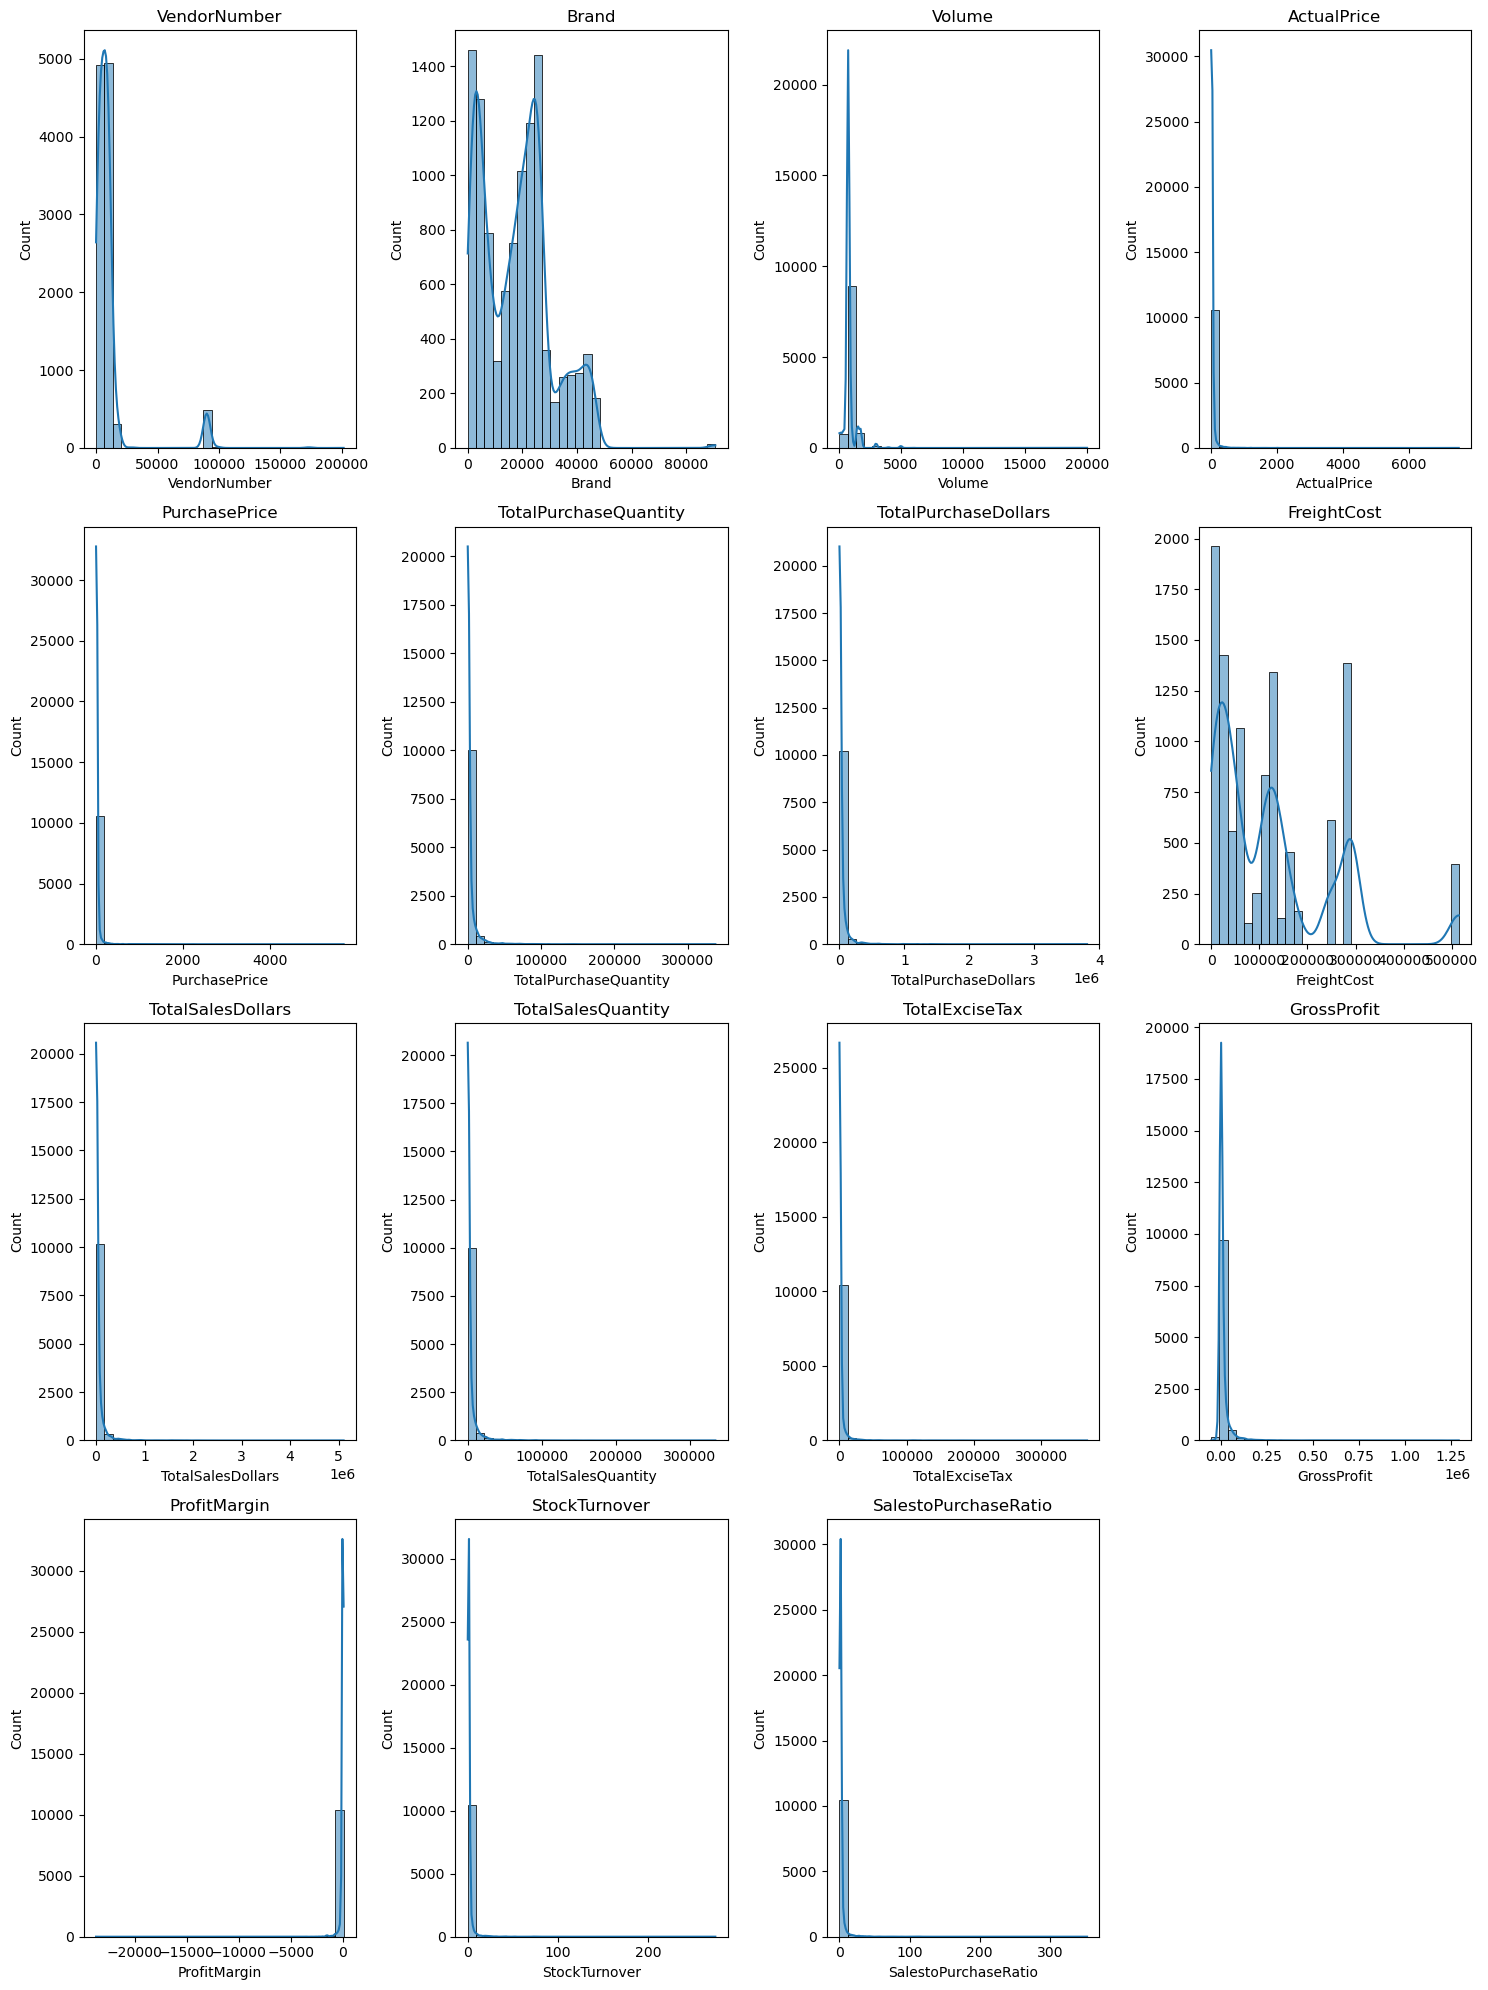

In [42]:
t = 1
plt.figure(figsize=(15,20))
for i in numeric_cols:
    plt.subplot(4,4,t)
    sns.histplot(df[i],kde=True,bins=30)
    plt.title(i)
    t+=1
plt.tight_layout()
plt.show()

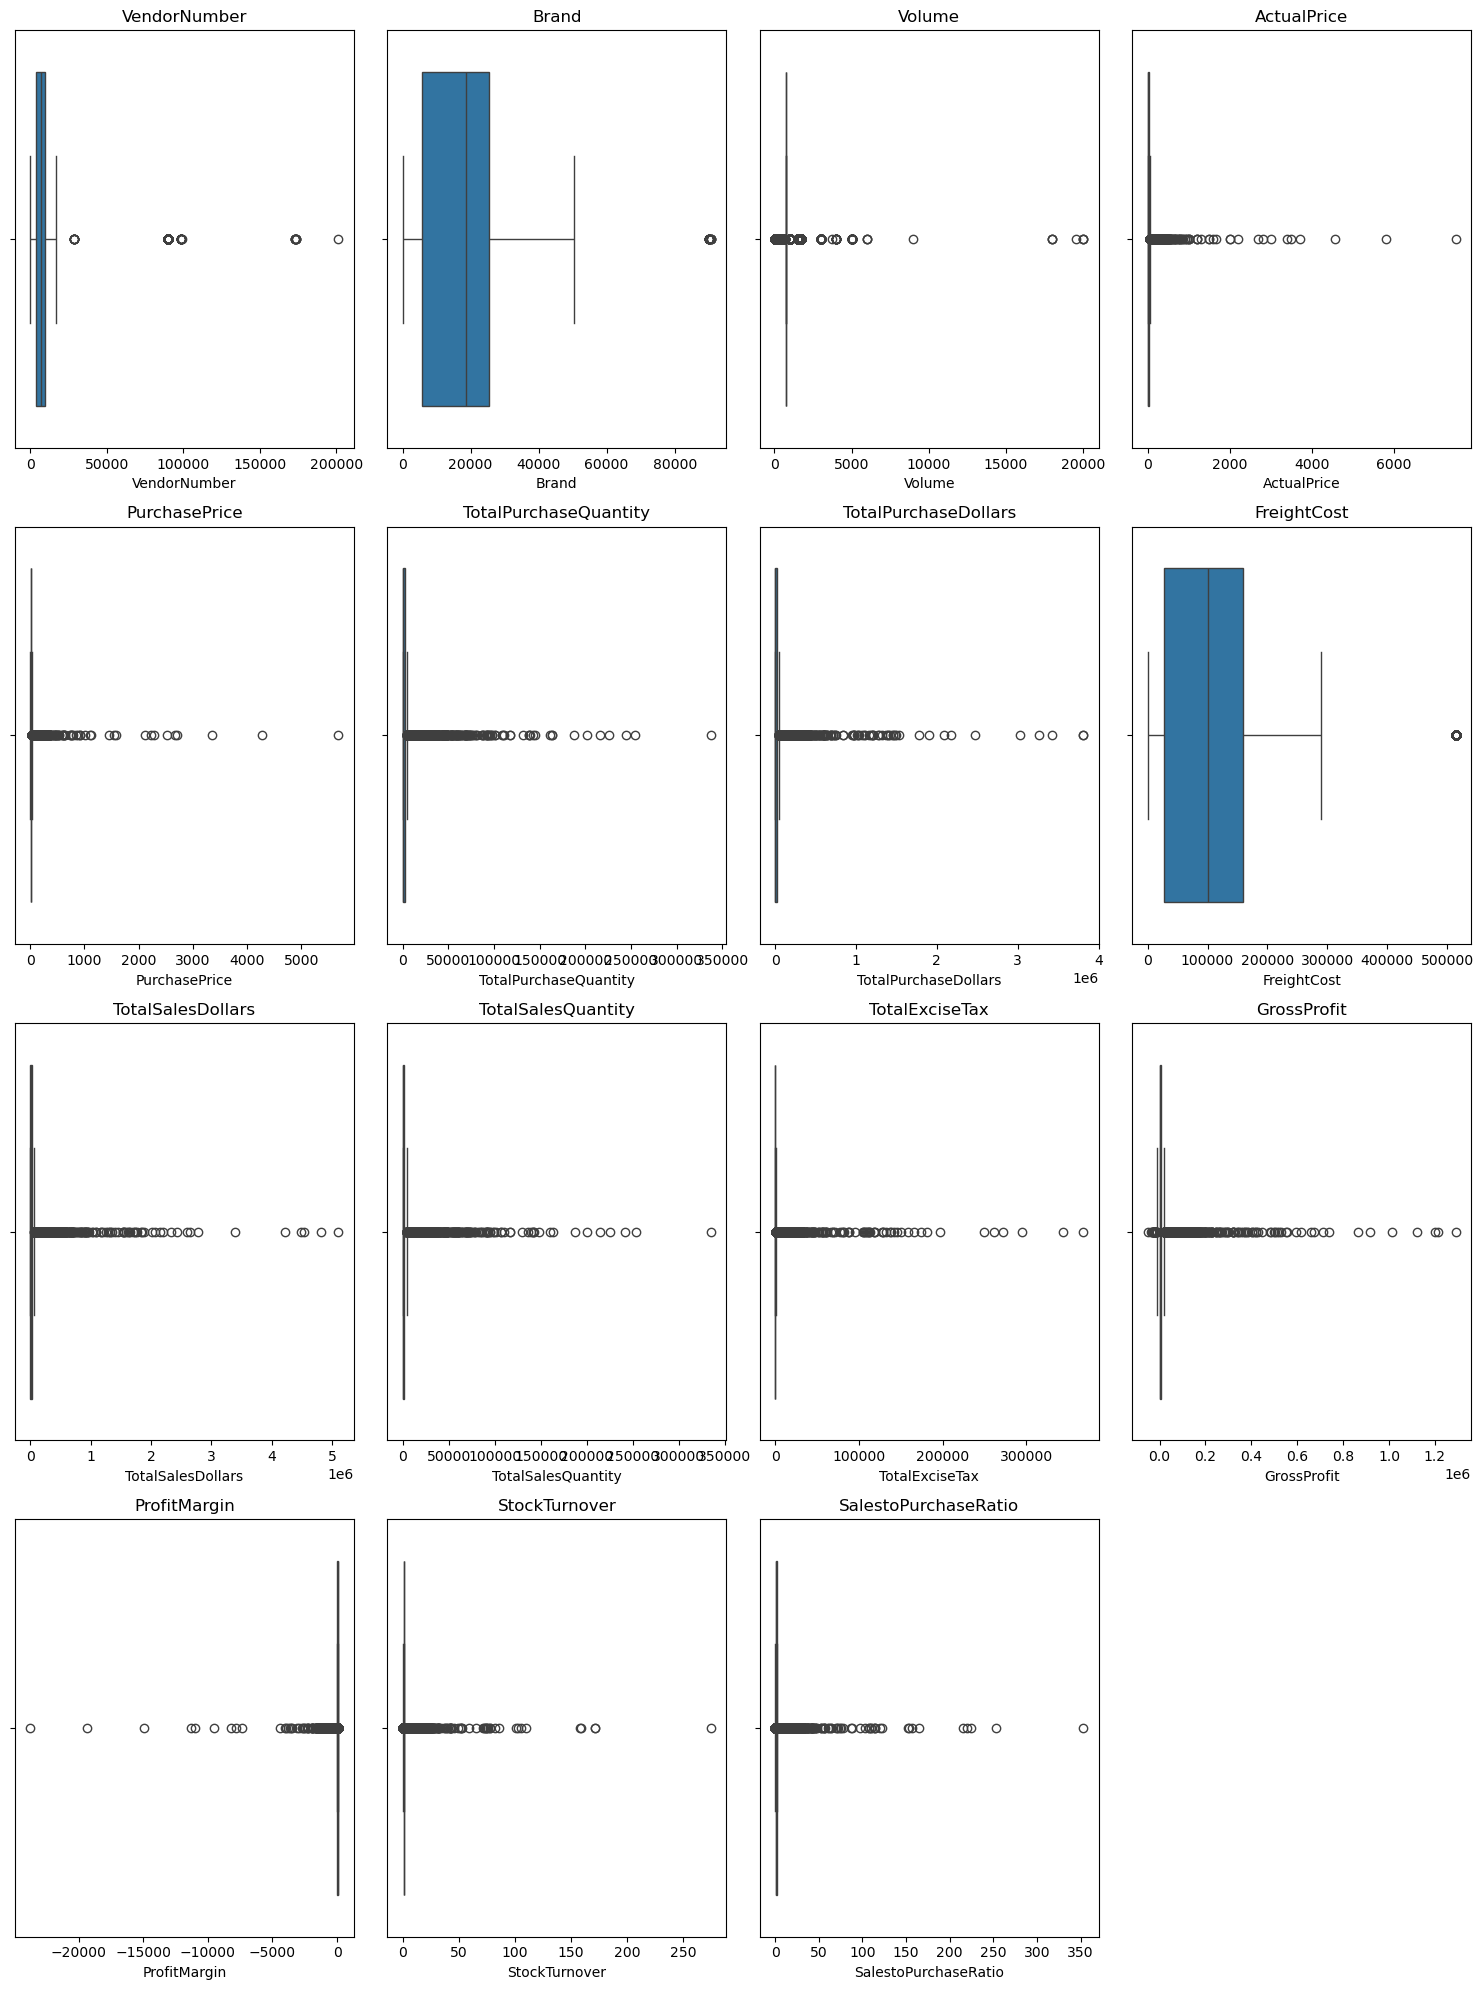

In [43]:
t = 1
plt.figure(figsize=(15,20))
for i in numeric_cols:
    plt.subplot(4,4,t)
    sns.boxplot(x=df[i])
    plt.title(i)
    t+=1
plt.tight_layout()
plt.show()

## Summary Statistics Insights:
#### Negative & Zero Values:
- Gross Profit: Minimum value is -52,002.78, indicating losses. Some products or transactions may be selling at a loss due to high costs or selling at discounts lower than the purchase price..
- Profit Margin: Has a minimum of -o, which suggests cases where revenue is zero or even lower than costs.
- Total Sales Quantity & Sales Dollars: Minimum values are 0, meaning some products were purchased but never sold. These could be slow-moving or obsolete stock.
#### Outliers Indicated by High Standard Deviations:
- Purchase & Actual Prices: The max values (5,681.81 & 7,499.99) are significantly higher than the mean (24.39 & 35.64), Indicating potential premium products.
- Freight Cost: Huge variation, from 0.09 to 257,032.07, suggests logistics inefficiencies or bulk shipments.
- Stock Turnover: Ranges from 0 to 274.5, implying some products sell extremely fast while others remain in stock indefinitely. Value more than 1 indicates that Sold quantity for that product is higher than purchased quantity due to either sales are being fulfilled from older stock.

In [44]:
# Let's filter the data by renoving inconsistencies
df = pd.read_sql_query(""" SELECT *
FROM Vendor_sales_
WHERE GrossProfit > 0
AND ProfitMargin > 0
AND TotalSalesQuantity>0""",conn)

In [45]:
df

,VendorNumber,VendorName,Brand,Description,Volume,ActualPrice,PurchasePrice,TotalPurchaseQuantity,TotalPurchaseDollars,FreightCost,TotalSalesDollars,TotalSalesQuantity,TotalExciseTax,GrossProfit,ProfitMargin,StockTurnover,SalestoPurchaseRatio
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,1750.0,36.99,26.27,145080,3811251.60,137203.36,5101919.51,142049.0,260999.20,1290667.91,25.297693,0.979108,1.338647
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,1750.0,28.99,23.19,164038,3804041.22,289858.48,4819073.49,160247.0,294438.66,1015032.27,21.062810,0.976890,1.266830
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,1750.0,24.99,18.24,187407,3418303.68,247560.44,4538120.60,187140.0,343854.07,1119816.92,24.675786,0.998575,1.327594
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,1750.0,22.99,16.17,201682,3261197.94,514064.14,4475972.88,200412.0,368242.80,1214774.94,27.139908,0.993703,1.372493
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,1750.0,29.99,21.89,138109,3023206.01,514064.14,4223107.62,135838.0,249587.83,1199901.61,28.412764,0.983556,1.396897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8559,9815,WINE GROUP INC,8527,Concannon Glen Ellen Wh Zin,750.0,4.99,1.32,2,2.64,54200.82,15.95,5.0,0.55,13.31,83.448276,2.500000,6.041667
8560,8004,SAZERAC CO INC,5683,Dr McGillicuddy's Apple Pie,50.0,0.49,0.39,6,2.34,100587.24,65.66,134.0,7.04,63.32,96.436186,22.333333,28.059829
8561,3924,HEAVEN HILL DISTILLERIES,9123,Deep Eddy Vodka,50.0,0.99,0.74,2,1.48,28139.74,1.98,2.0,0.10,0.50,25.252525,1.000000,1.337838
8562,3960,DIAGEO NORTH AMERICA INC,6127,The Club Strawbry Margarita,200.0,1.99,1.47,1,1.47,514064.14,143.28,72.0,15.12,141.81,98.974037,72.000000,97.469388


<Axes: xlabel='count', ylabel='VendorName'>

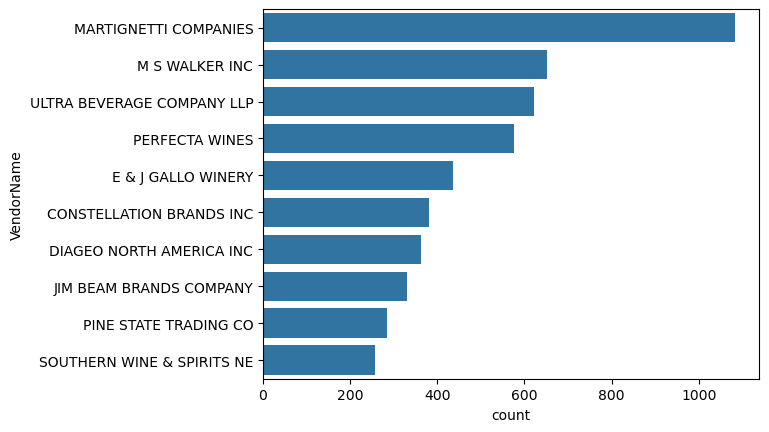

In [46]:
sns.countplot(y=df['VendorName'],order=df['VendorName'].value_counts().index[:10])

<Axes: xlabel='count', ylabel='Description'>

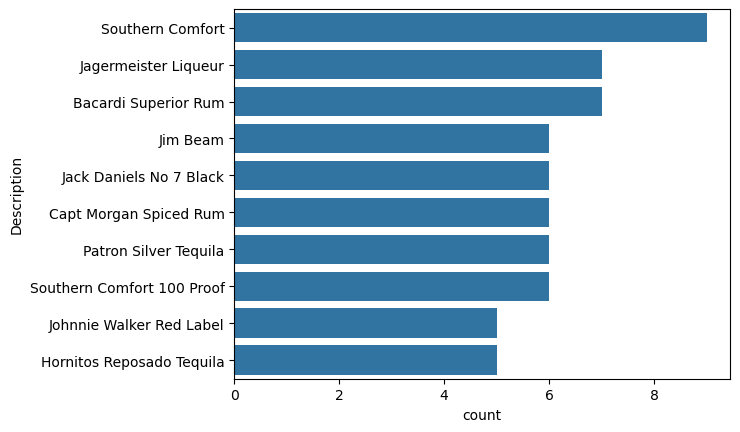

In [47]:
sns.countplot(y=df['Description'],order=df['Description'].value_counts().index[:10])

In [48]:
plt.rcParams['figure.figsize']=[15,20]

Text(0.5, 1.0, 'correlation Heatmap')

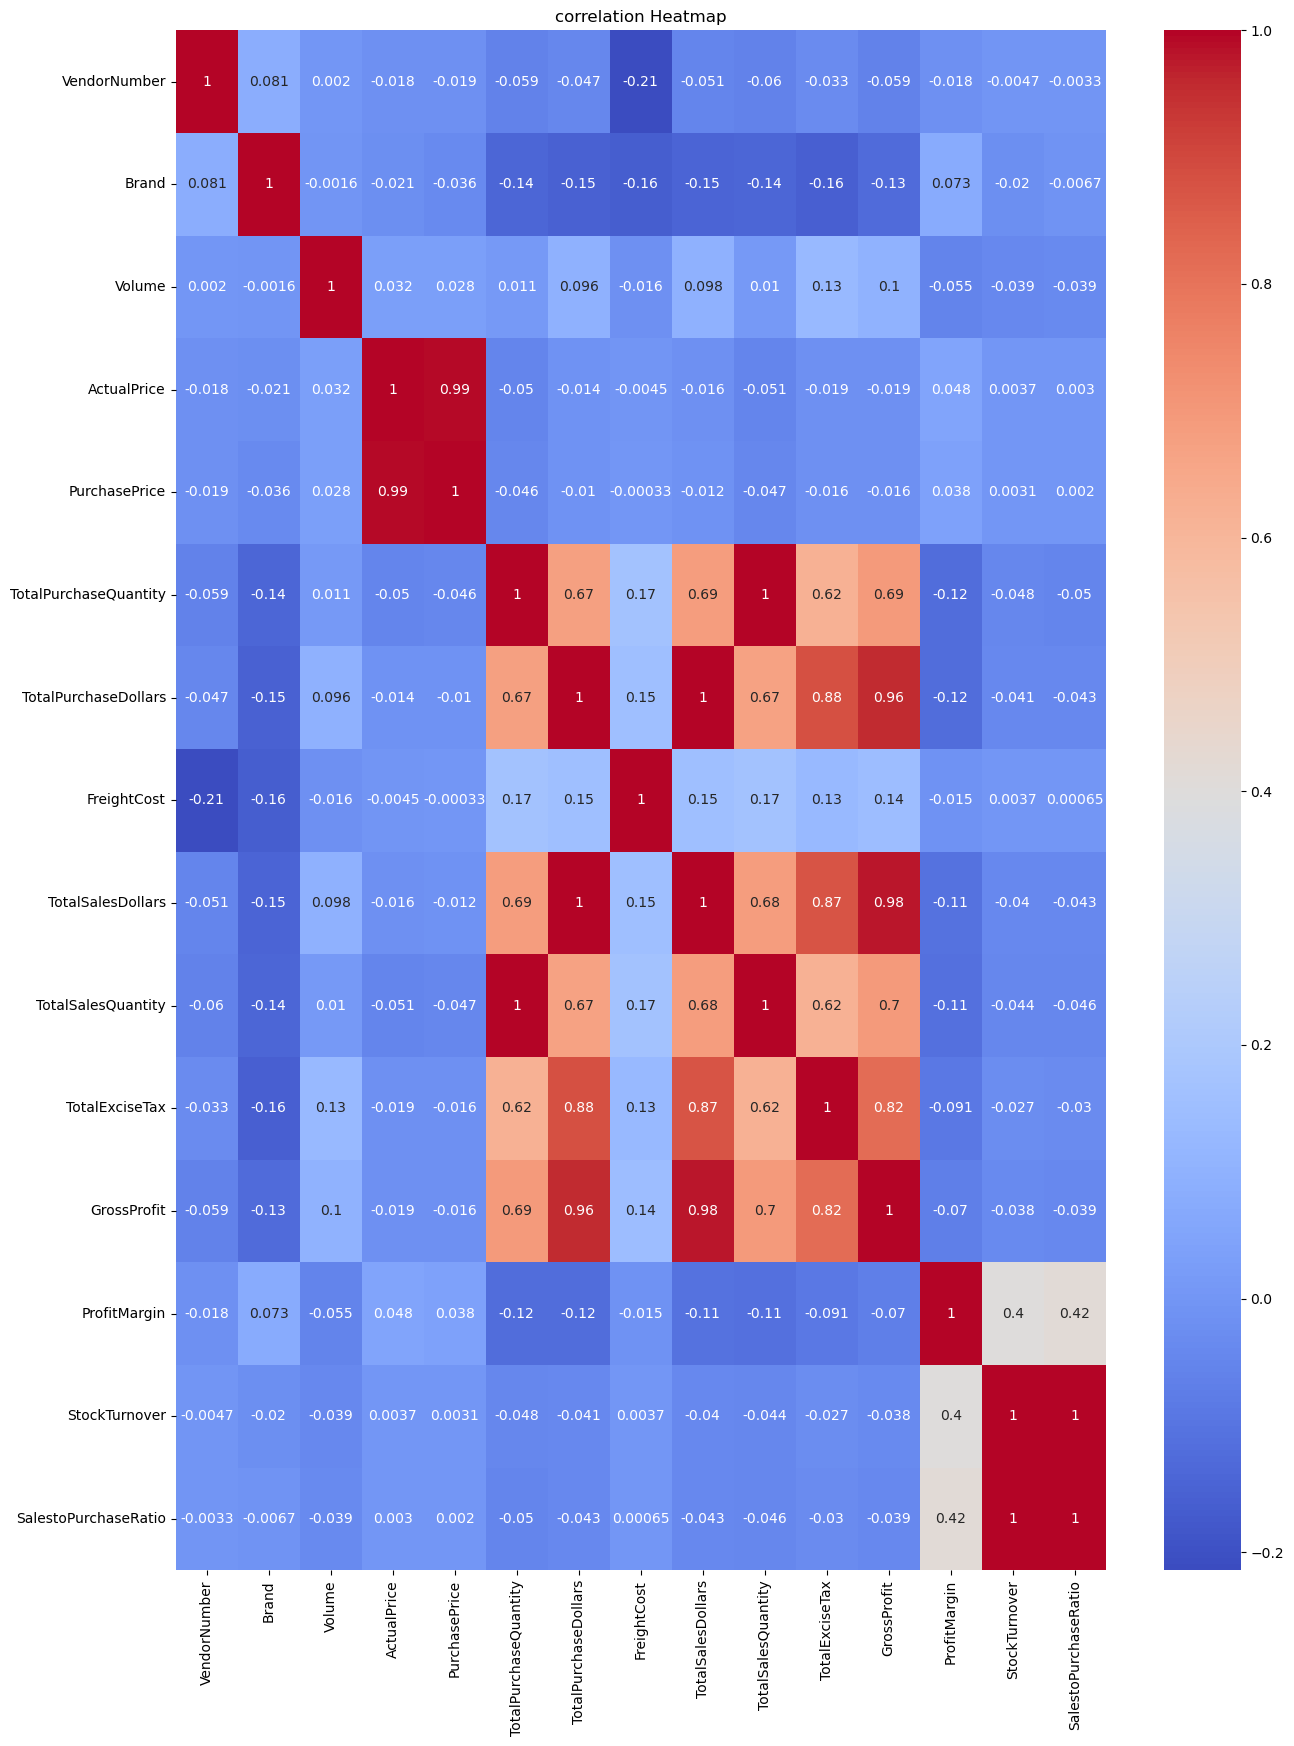

In [49]:
sns.heatmap(df[numeric_cols].corr(),annot=True,cmap='coolwarm')
plt.title('correlation Heatmap')

## Correlation Insights
- PurchasePrice has weak correlations with TotalSalesDollars (-0.012) and GrossProfit (-0.016), suggesting that price variations do not significantly impact sales revenue or profic
- Strong correlation between total purchase quantity and total sales quantity (0.999), confirming efficient inventory turnover.
- StockTurnover has weak negative correlations with both GrossProfit (-0.038) and ProfitMargin (-0.055), indicating that faster turnover does not necessarily result in higher profitability.

## Data Analysis

#### identify brands that needs promotional or pricing adjusments which exhibit lower sales performance but higher profit margins.

In [50]:
brand_performance=df.groupby('Description').agg({'TotalSalesDollars':'sum','ProfitMargin':'mean'}).reset_index()

In [51]:
low_sales_thresold=brand_performance['TotalSalesDollars'].quantile(0.15)
high_margin_thresold=brand_performance['ProfitMargin'].quantile(0.85)

In [52]:
low_sales_thresold

np.float64(560.299)

In [53]:
high_margin_thresold

np.float64(64.97017552750113)

In [54]:
target_brands=brand_performance[(brand_performance['TotalSalesDollars']<=low_sales_thresold)&
(brand_performance['ProfitMargin']>=high_margin_thresold)]


In [55]:
display(target_brands)

,Description,TotalSalesDollars,ProfitMargin
6,12 Days of Pearls Gift Set,309.69,97.678323
45,4 Orange Vodka,483.78,85.902683
57,A Bichot Clos Marechaudes,539.94,67.740860
59,A Bichot Merc Champs M,515.88,94.552997
96,Absolut Orient Apple Vodka,119.94,87.652159
...,...,...,...
7588,Woodford Rsv Master Coll Pnt,489.95,73.760588
7663,Zardetto Pros di Coneg Brut,345.86,88.758457
7677,Zerran Tinto Montsant,139.91,77.592738
7686,Zhenka Vodka 80 Proof,240.39,87.303964


In [56]:
brand_performance=brand_performance[brand_performance['TotalSalesDollars']<10000]# for better visualization

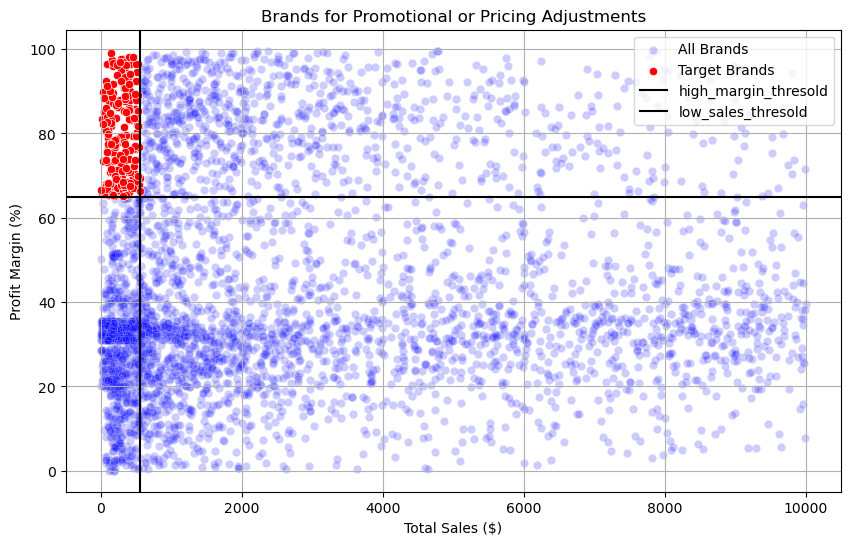

In [57]:
plt.figure(figsize=(10, 6))

# Scatter plot for all brands
sns.scatterplot(
    data=brand_performance,
    x='TotalSalesDollars',
    y='ProfitMargin',
    color="blue",
    label="All Brands",
    alpha=0.2
)

# Scatter plot for target brands
sns.scatterplot(
    data=target_brands,
    x='TotalSalesDollars',
    y='ProfitMargin',
    color="red",
    label="Target Brands"
)

# Threshold lines
plt.axhline(
    high_margin_thresold,
    linestyle='-',
    color='black',
    label="high_margin_thresold"
)

plt.axvline(
    low_sales_thresold,
    linestyle='-',
    color='black',
    label="low_sales_thresold"
)

# Labels & title
plt.xlabel("Total Sales ($)")
plt.ylabel("Profit Margin (%)")
plt.title("Brands for Promotional or Pricing Adjustments")

plt.legend()
plt.grid(True)
plt.show()


#### which vendors and brands demonstrate the highest sales performance ?

In [58]:
top_vendors=df.groupby('VendorName')['TotalSalesDollars'].sum().nlargest(10)
top_brands=df.groupby('Description')['TotalSalesDollars'].sum().nlargest(10)

In [59]:
top_vendors

VendorName
DIAGEO NORTH AMERICA INC      67990099.42
MARTIGNETTI COMPANIES         39330359.36
PERNOD RICARD USA             32063196.19
JIM BEAM BRANDS COMPANY       31423020.46
BACARDI USA INC               24854817.14
CONSTELLATION BRANDS INC      24218745.65
E & J GALLO WINERY            18399899.46
BROWN-FORMAN CORP             18247230.65
ULTRA BEVERAGE COMPANY LLP    16502544.31
M S WALKER INC                14706458.51
Name: TotalSalesDollars, dtype: float64

In [60]:
top_brands

Description
Jack Daniels No 7 Black    7964746.76
Tito's Handmade Vodka      7399657.58
Grey Goose Vodka           7209608.06
Capt Morgan Spiced Rum     6356320.62
Absolut 80 Proof           6244752.03
Jameson Irish Whiskey      5715759.69
Ketel One Vodka            5070083.56
Baileys Irish Cream        4150122.07
Kahlua                     3604858.66
Tanqueray                  3456697.90
Name: TotalSalesDollars, dtype: float64

In [61]:
def format_dollars(value):
    if value is None:
        return None
    value = float(value)

    if abs(value) >= 1_000_000_000:
        return f"${value/1_000_000_000:.2f}B"
    elif abs(value) >= 1_000_000:
        return f"${value/1_000_000:.2f}M"
    elif abs(value) >= 1_000:
        return f"${value/1_000:.2f}K"
    else:
        return f"${value:.2f}"


In [62]:
top_brands.apply(lambda x : format_dollars(x))

Description
Jack Daniels No 7 Black    $7.96M
Tito's Handmade Vodka      $7.40M
Grey Goose Vodka           $7.21M
Capt Morgan Spiced Rum     $6.36M
Absolut 80 Proof           $6.24M
Jameson Irish Whiskey      $5.72M
Ketel One Vodka            $5.07M
Baileys Irish Cream        $4.15M
Kahlua                     $3.60M
Tanqueray                  $3.46M
Name: TotalSalesDollars, dtype: object

In [63]:
top_vendors.apply(lambda x : format_dollars(x))

VendorName
DIAGEO NORTH AMERICA INC      $67.99M
MARTIGNETTI COMPANIES         $39.33M
PERNOD RICARD USA             $32.06M
JIM BEAM BRANDS COMPANY       $31.42M
BACARDI USA INC               $24.85M
CONSTELLATION BRANDS INC      $24.22M
E & J GALLO WINERY            $18.40M
BROWN-FORMAN CORP             $18.25M
ULTRA BEVERAGE COMPANY LLP    $16.50M
M S WALKER INC                $14.71M
Name: TotalSalesDollars, dtype: object

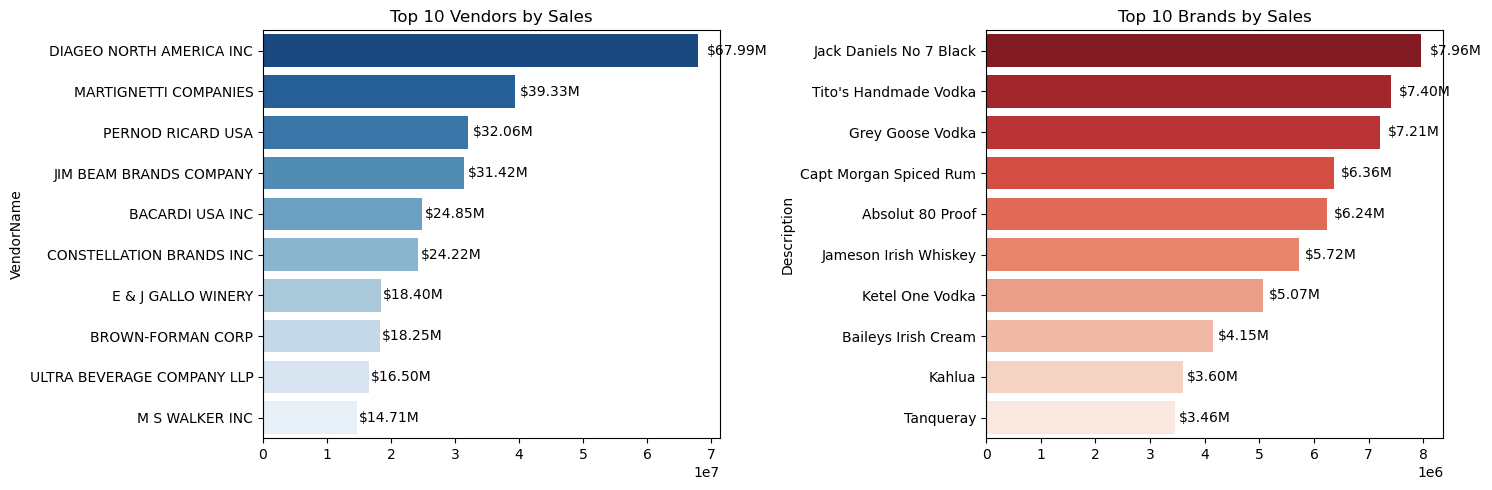

In [64]:
plt.figure(figsize=(15, 5))

# Plot for Top Vendors
plt.subplot(1, 2, 1)
ax1 = sns.barplot(y=top_vendors.index, x=top_vendors.values, palette="Blues_r")
plt.title("Top 10 Vendors by Sales")

for bar in ax1.patches:
    ax1.text(bar.get_width() + (bar.get_width() * 0.02),
             bar.get_y() + bar.get_height() / 2,
             format_dollars(bar.get_width()),
             ha='left', va='center', fontsize=10, color='black')

# Plot for Top Brands
plt.subplot(1, 2, 2)
ax2 = sns.barplot(y=top_brands.index.astype(str), x=top_brands.values, palette="Reds_r")
plt.title("Top 10 Brands by Sales")

for bar in ax2.patches:
    ax2.text(bar.get_width() + (bar.get_width() * 0.02),
             bar.get_y() + bar.get_height() / 2,
             format_dollars(bar.get_width()),
             ha='left', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()


#### which vendors contributes the most to total purchase dollars?


In [65]:
vendor_performance=df.groupby('VendorName').agg({'TotalPurchaseDollars':'sum','GrossProfit':'sum','TotalSalesDollars':'sum'}).reset_index()

In [66]:
vendor_performance['purchase_contribution']=vendor_performance['TotalPurchaseDollars']/vendor_performance['TotalPurchaseDollars'].sum()*100

In [67]:
vendor_performance=round(vendor_performance.sort_values(by='purchase_contribution',ascending=False),2)

In [68]:
# Display Top 10 Vendors
top_vendors = vendor_performance.head(10)
top_vendors ['TotalSalesDollars' ] = top_vendors ['TotalSalesDollars' ]. apply(format_dollars)
top_vendors ['TotalPurchaseDollars' ] = top_vendors ['TotalPurchaseDollars' ]. apply(format_dollars)
top_vendors ['GrossProfit' ] = top_vendors ['GrossProfit']. apply(format_dollars)
top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,purchase_contribution
25,DIAGEO NORTH AMERICA INC,$50.10M,$17.89M,$67.99M,16.30
57,MARTIGNETTI COMPANIES,$25.50M,$13.83M,$39.33M,8.30
68,PERNOD RICARD USA,$23.85M,$8.21M,$32.06M,7.76
46,JIM BEAM BRANDS COMPANY,$23.49M,$7.93M,$31.42M,7.64
6,BACARDI USA INC,$17.43M,$7.42M,$24.85M,5.67
20,CONSTELLATION BRANDS INC,$15.27M,$8.95M,$24.22M,4.97
11,BROWN-FORMAN CORP,$13.24M,$5.01M,$18.25M,4.31
30,E & J GALLO WINERY,$12.07M,$6.33M,$18.40M,3.93
106,ULTRA BEVERAGE COMPANY LLP,$11.17M,$5.34M,$16.50M,3.63
53,M S WALKER INC,$9.76M,$4.94M,$14.71M,3.18


In [69]:
top_vendors['purchase_contribution'].sum()

np.float64(65.69000000000001)

In [70]:
top_vendors['cumulative_contribution']=top_vendors['purchase_contribution'].cumsum()*100

In [71]:
top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,purchase_contribution,cumulative_contribution
25,DIAGEO NORTH AMERICA INC,$50.10M,$17.89M,$67.99M,16.30,1630.0
57,MARTIGNETTI COMPANIES,$25.50M,$13.83M,$39.33M,8.30,2460.0
68,PERNOD RICARD USA,$23.85M,$8.21M,$32.06M,7.76,3236.0
46,JIM BEAM BRANDS COMPANY,$23.49M,$7.93M,$31.42M,7.64,4000.0
6,BACARDI USA INC,$17.43M,$7.42M,$24.85M,5.67,4567.0
20,CONSTELLATION BRANDS INC,$15.27M,$8.95M,$24.22M,4.97,5064.0
11,BROWN-FORMAN CORP,$13.24M,$5.01M,$18.25M,4.31,5495.0
30,E & J GALLO WINERY,$12.07M,$6.33M,$18.40M,3.93,5888.0
106,ULTRA BEVERAGE COMPANY LLP,$11.17M,$5.34M,$16.50M,3.63,6251.0
53,M S WALKER INC,$9.76M,$4.94M,$14.71M,3.18,6569.0


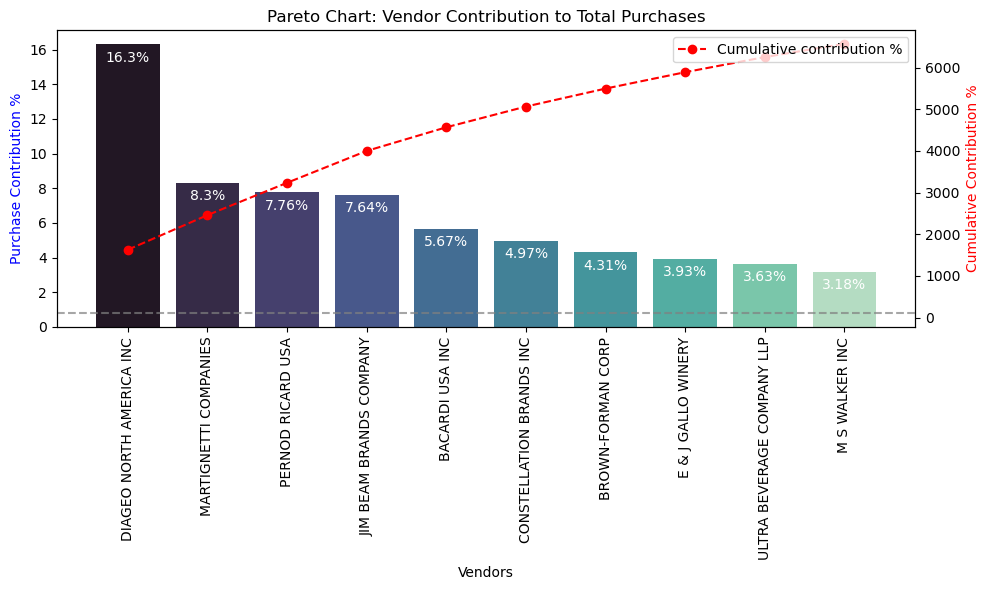

In [72]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for Purchase Contribution
sns.barplot(x=top_vendors['VendorName'], 
            y=top_vendors['purchase_contribution'], 
            palette="mako", 
            ax=ax1)

for i, value in enumerate(top_vendors['purchase_contribution']):
    ax1.text(i, value - 1, str(value) + '%', ha='center', fontsize=10, color='white')

# Line Plot for Cumulative Contribution
ax2 = ax1.twinx()
ax2.plot(top_vendors['VendorName'], 
         top_vendors['cumulative_contribution'], 
         color='red', marker='o', linestyle='dashed', 
         label='Cumulative contribution %')

# Fix tick labels for modern matplotlib
ax1.set_xticks(range(len(top_vendors['VendorName'])))
ax1.set_xticklabels(top_vendors['VendorName'], rotation=90)

ax1.set_ylabel('Purchase Contribution %', color='blue')
ax2.set_ylabel('Cumulative Contribution %', color='red')
ax1.set_xlabel('Vendors')
ax1.set_title('Pareto Chart: Vendor Contribution to Total Purchases')

ax2.axhline(y=100, color='gray', linestyle='dashed', alpha=0.7)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


#### How much of total procurement is dependent on the top vendors?

In [73]:
print(f'Total purchase contribution of top 10 vendors is {round(top_vendors['purchase_contribution'].sum(),2)}%')

Total purchase contribution of top 10 vendors is 65.69%


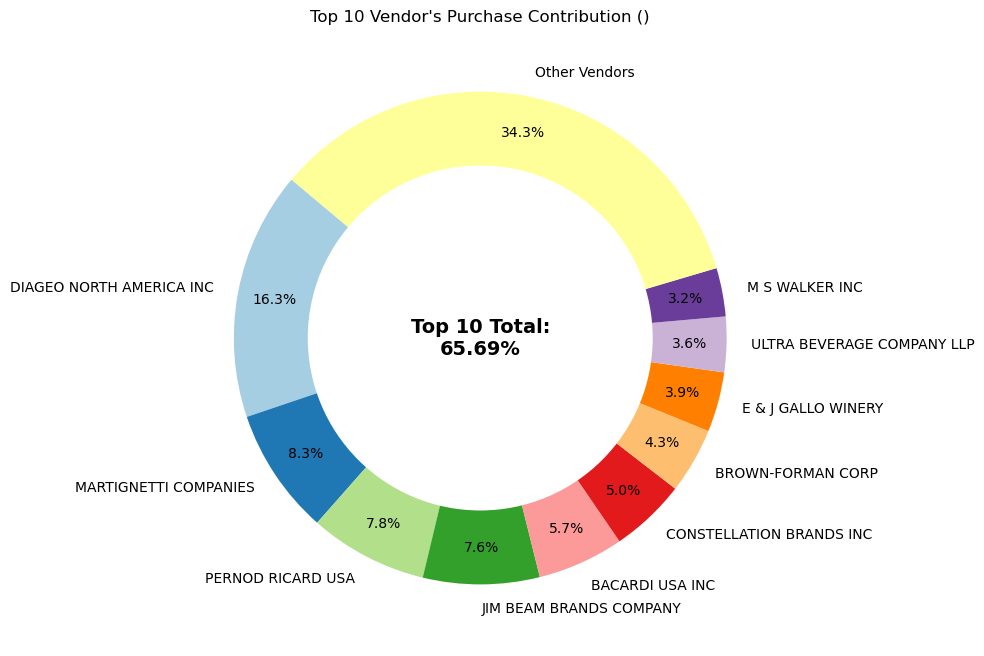

In [74]:
vendors = list(top_vendors ['VendorName' ]. values)
purchase_contributions = list(top_vendors ['purchase_contribution'].values)
total_contribution = sum(purchase_contributions)
remaining_contribution = 100 - total_contribution

# Append "Other Vendors" category
vendors.append("Other Vendors")
purchase_contributions.append(remaining_contribution)

# Donut Chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax. pie(purchase_contributions, labels=vendors, autopct='%1.1f%%',
startangle=140, pctdistance=0.85, colors=plt.cm.Paired.colors)

# Draw a white circle in the center to create a "donut" effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Add Total Contribution annotation in the center
plt.text(0, 0, f"Top 10 Total:\n{total_contribution :.2f}%", fontsize=14, fontweight='bold', ha='center', va='center')

plt.title("Top 10 Vendor's Purchase Contribution ()")
plt.show()



#### does purchasing in bulk reduce the unit price and what is the optimal purchase volume for cost savings?

In [76]:
df['unitpurchaseprice']=df['TotalPurchaseDollars']/df['TotalPurchaseQuantity'] 

In [77]:
df

,VendorNumber,VendorName,Brand,Description,Volume,ActualPrice,PurchasePrice,TotalPurchaseQuantity,TotalPurchaseDollars,FreightCost,TotalSalesDollars,TotalSalesQuantity,TotalExciseTax,GrossProfit,ProfitMargin,StockTurnover,SalestoPurchaseRatio,unitpurchaseprice
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,1750.0,36.99,26.27,145080,3811251.60,137203.36,5101919.51,142049.0,260999.20,1290667.91,25.297693,0.979108,1.338647,26.27
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,1750.0,28.99,23.19,164038,3804041.22,289858.48,4819073.49,160247.0,294438.66,1015032.27,21.062810,0.976890,1.266830,23.19
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,1750.0,24.99,18.24,187407,3418303.68,247560.44,4538120.60,187140.0,343854.07,1119816.92,24.675786,0.998575,1.327594,18.24
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,1750.0,22.99,16.17,201682,3261197.94,514064.14,4475972.88,200412.0,368242.80,1214774.94,27.139908,0.993703,1.372493,16.17
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,1750.0,29.99,21.89,138109,3023206.01,514064.14,4223107.62,135838.0,249587.83,1199901.61,28.412764,0.983556,1.396897,21.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8559,9815,WINE GROUP INC,8527,Concannon Glen Ellen Wh Zin,750.0,4.99,1.32,2,2.64,54200.82,15.95,5.0,0.55,13.31,83.448276,2.500000,6.041667,1.32
8560,8004,SAZERAC CO INC,5683,Dr McGillicuddy's Apple Pie,50.0,0.49,0.39,6,2.34,100587.24,65.66,134.0,7.04,63.32,96.436186,22.333333,28.059829,0.39
8561,3924,HEAVEN HILL DISTILLERIES,9123,Deep Eddy Vodka,50.0,0.99,0.74,2,1.48,28139.74,1.98,2.0,0.10,0.50,25.252525,1.000000,1.337838,0.74
8562,3960,DIAGEO NORTH AMERICA INC,6127,The Club Strawbry Margarita,200.0,1.99,1.47,1,1.47,514064.14,143.28,72.0,15.12,141.81,98.974037,72.000000,97.469388,1.47


In [78]:
df['OrderSize']=pd.qcut(df['TotalPurchaseQuantity'],q=3,labels=['small','medium','large'])

In [79]:
df.groupby('OrderSize')[['unitpurchaseprice']].mean()

,unitpurchaseprice
OrderSize,
small,39.068186
medium,15.486414
large,10.777625


Text(0.5, 1.0, 'Impact of Bulk purchasing on Unit price')

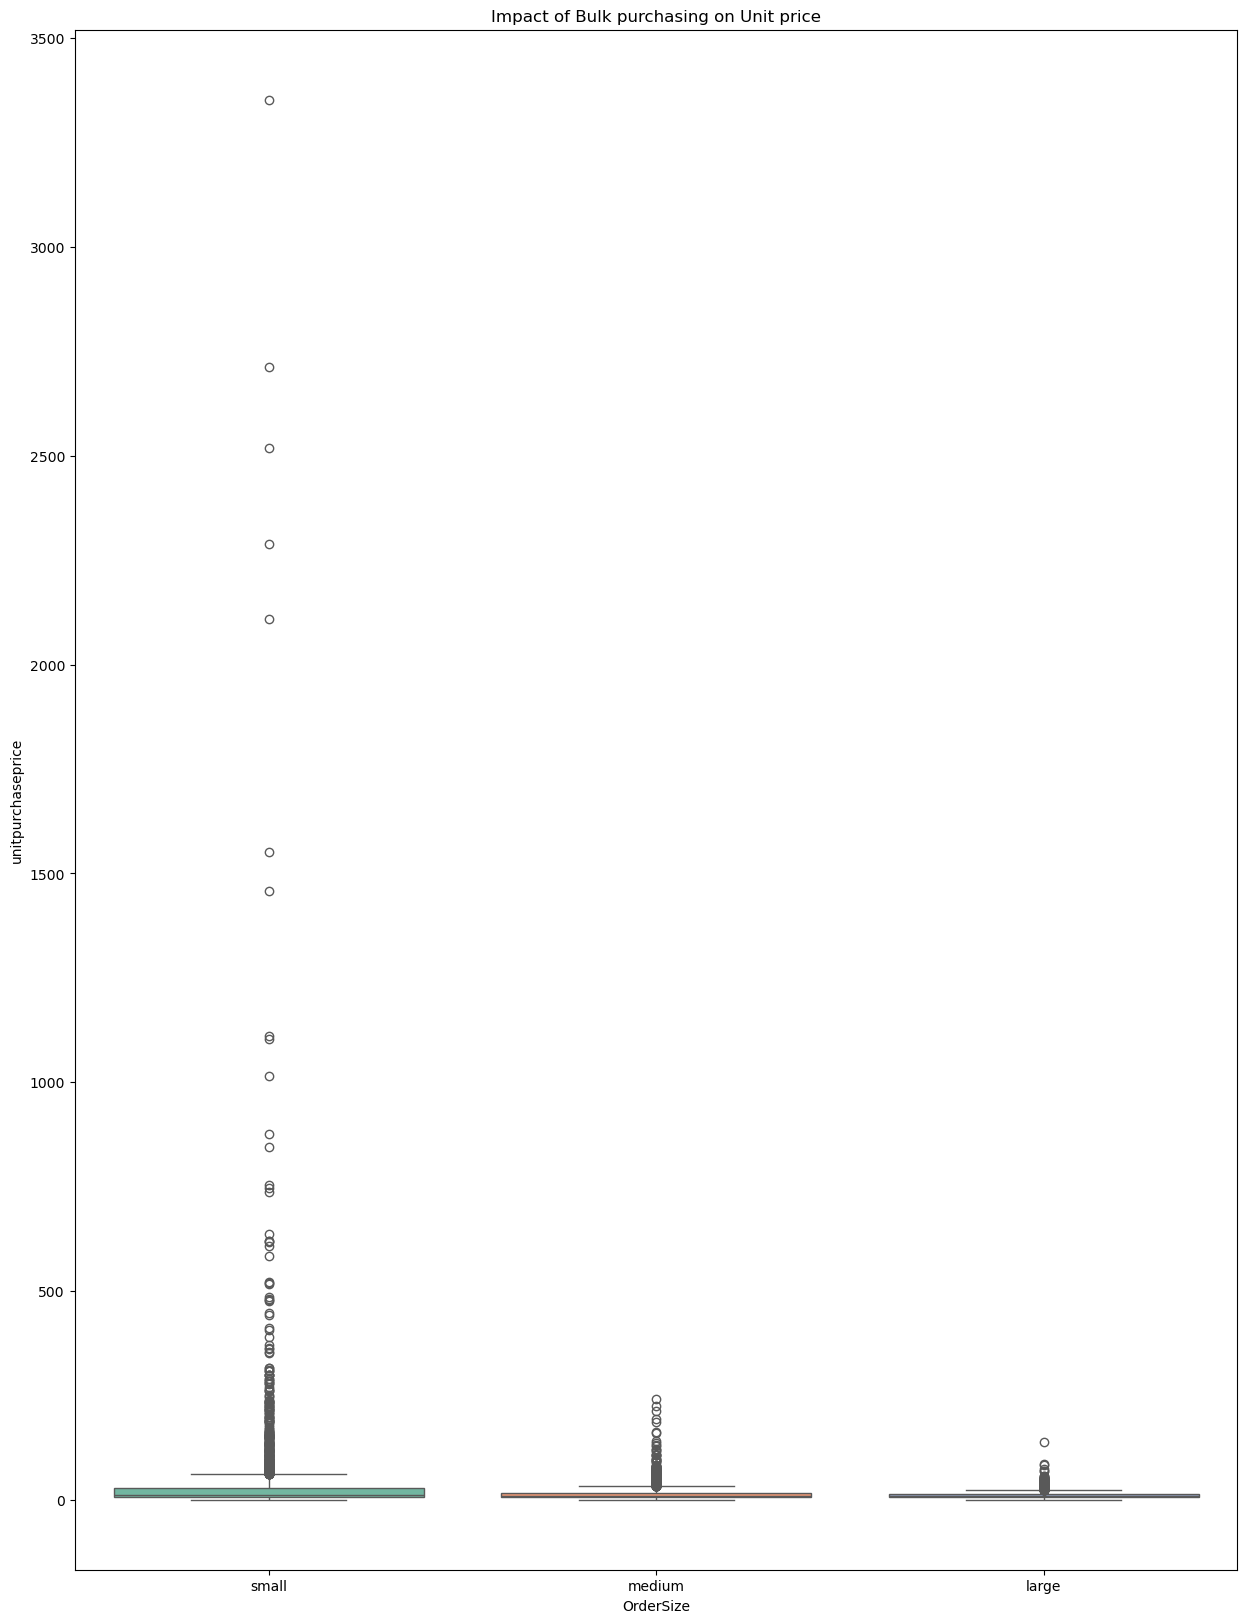

In [83]:
sns.boxplot(data=df,x='OrderSize',y='unitpurchaseprice',palette='Set2')
plt.title('Impact of Bulk purchasing on Unit price')


- Vendors buying in bulk (Large Order Size) get the lowest unit price ($10.78 per unit), meaning higher margins if they can manage inventory efficiently.
- The price difference between Small and Large orders is substantial (-72% reduction in unit cost)
- This suggests that bulk pricing strategies successfully encourage vendors to purchase in larger volumes, leading to higher overall sales despite lower per-unit
revenue.

#### which Vendors have low inventory turnover,indicating excess stock and slow-moving products?

In [89]:

df[df['StockTurnover']<1].groupby('VendorName')[['StockTurnover']].mean().sort_values(by='StockTurnover').head(10)

,StockTurnover
VendorName,
ALISA CARR BEVERAGES,0.615385
HIGHLAND WINE MERCHANTS LLC,0.708333
PARK STREET IMPORTS LLC,0.751306
Circa Wines,0.755676
Dunn Wine Brokers,0.766022
CENTEUR IMPORTS LLC,0.773953
SMOKY QUARTZ DISTILLERY LLC,0.783835
TAMWORTH DISTILLING,0.797078
THE IMPORTED GRAPE LLC,0.807569


#### how much capital is locked in unsold inventory per vendor,and which vendors contribute the most to it ?

In [90]:
df ["UnsoldInventoryValue"] = (df ["TotalPurchaseQuantity"] - df ["TotalSalesQuantity"]) * df ["PurchasePrice"]
print('Total Unsold Capital:', format_dollars(df["UnsoldInventoryValue"]. sum( ) ) )

Total Unsold Capital: $2.71M


In [91]:

# Aggregate Capital Locked per Vendor
inventory_value_per_vendor = df.groupby("VendorName") ["UnsoldInventoryValue"].sum(). reset_index()

inventory_value_per_vendor = inventory_value_per_vendor.sort_values(by="UnsoldInventoryValue", ascending=False)
inventory_value_per_vendor ['UnsoldInventoryValue'] = inventory_value_per_vendor ['UnsoldInventoryValue']. apply(format_dollars)
inventory_value_per_vendor.head(10)


,VendorName,UnsoldInventoryValue
25,DIAGEO NORTH AMERICA INC,$722.21K
46,JIM BEAM BRANDS COMPANY,$554.67K
68,PERNOD RICARD USA,$470.63K
116,WILLIAM GRANT & SONS INC,$401.96K
30,E & J GALLO WINERY,$228.28K
79,SAZERAC CO INC,$198.44K
11,BROWN-FORMAN CORP,$177.73K
20,CONSTELLATION BRANDS INC,$133.62K
61,MOET HENNESSY USA INC,$126.48K
77,REMY COINTREAU USA INC,$118.60K


#### what is the confidence intervals for profit margins of top-performing and low-performing vendors

In [92]:
top_threshold = df['TotalSalesDollars'].quantile(0.75)
low_threshold = df['TotalSalesDollars'].quantile(0.25)

In [93]:
top_vendors=df[df['TotalSalesDollars']>= top_threshold]['ProfitMargin'].dropna()
low_vendors=df[df['TotalSalesDollars']<= low_threshold]['ProfitMargin'].dropna()

In [95]:
def confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(len(data)) # Standard error
    t_critical = stats.t.ppf((1 + confidence) / 2, df=len(data) - 1)
    margin_of_error = t_critical * std_err
    return mean_val, mean_val - margin_of_error, mean_val + margin_of_error

Top Vendors 95% CI: (30.74, 31.61), Mean: 31.18
Low Vendors 95% CI: (40.50, 42.64), Mean: 41.57


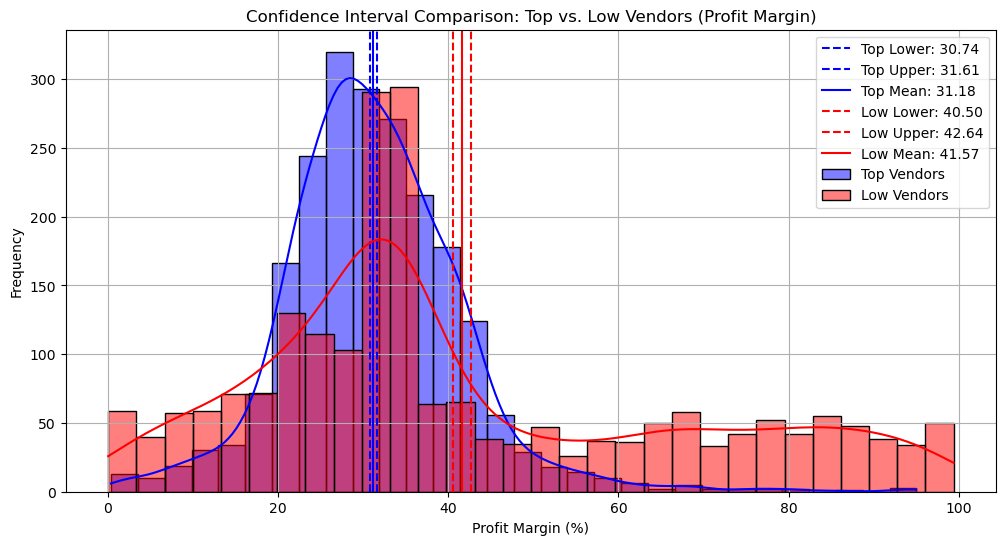

In [100]:
top_mean, top_lower, top_upper = confidence_interval(top_vendors)
low_mean, low_lower, low_upper = confidence_interval(low_vendors)

print(f"Top Vendors 95% CI: ({top_lower:.2f}, {top_upper:.2f}), Mean: {top_mean:.2f}")
print(f"Low Vendors 95% CI: ({low_lower:.2f}, {low_upper:.2f}), Mean: {low_mean:.2f}")

plt.figure(figsize=(12, 6))

# Top Vendors Plot
sns.histplot(top_vendors, kde=True, color="blue", bins=30, alpha=0.5, label="Top Vendors")
plt.axvline(top_lower, color="blue", linestyle="--", label=f"Top Lower: {top_lower:.2f}")
plt.axvline(top_upper, color="blue", linestyle="--", label=f"Top Upper: {top_upper:.2f}")
plt.axvline(top_mean, color="blue", linestyle="-", label=f"Top Mean: {top_mean:.2f}")

# Low Vendors Plot
sns.histplot(low_vendors, kde=True, color="red", bins=30, alpha=0.5, label="Low Vendors")
plt.axvline(low_lower, color="red", linestyle="--", label=f"Low Lower: {low_lower:.2f}")
plt.axvline(low_upper, color="red", linestyle="--", label=f"Low Upper: {low_upper:.2f}")
plt.axvline(low_mean, color="red", linestyle="-", label=f"Low Mean: {low_mean:.2f}")

# Finalize Plot
plt.title("Confidence Interval Comparison: Top vs. Low Vendors (Profit Margin)")
plt.xlabel("Profit Margin (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


- The confidence interval for low-performing vendors (40.48% to 42.62%) is significantly higher than that of top-performing vendors (30.74% to 31.61%).
- This suggests that vendors with lower sales tend to maintain higher profit margins, potentially due to premium pricing or lower operational costs.
- For High-Performing Vendors: If they aim to improve profitability, they could explore selective price adjustments, cost optimization, or bundling strategies.
- For Low-Performing Vendors: Despite higher margins, their low sales volume might indicate a need for better marketing, competitive pricing, or improved
distribution strategies.

#### Is there a significant difference in profit margins between top-performing and low-performing vendors?
Hypothesis:

Ho (Null Hypothesis): There is no significant difference in the mean profit margins of top-performing and low-performing vendors.

H1 (Alternative Hypothesis): The mean profit margins of top-performing and low-performing vendors are significantly different.

In [104]:
top_threshold = df ["TotalSalesDollars"].quantile(0.75)
low_threshold = df["TotalSalesDollars"].quantile(0.25)

top_vendors = df [df["TotalSalesDollars"] >= top_threshold] ["ProfitMargin"] . dropna( )
low_vendors = df [df ["TotalSalesDollars"] <= low_threshold] ["ProfitMargin"]. dropna( )

# Perform Two-Sample T-Test
t_stat, p_value = ttest_ind(top_vendors, low_vendors, equal_var=False)

# Print results
print(f"T-Statistic: {t_stat :.4f}, P-Value: {p_value :.4f}")
if p_value < 0.05:
    print("Reject Ho: There is a significant difference in profit margins between top and low-performing vendors.")
else:
    print("Fail to Reject Ho: No significant difference in profit margins.")

T-Statistic: -17.6695, P-Value: 0.0000
Reject Ho: There is a significant difference in profit margins between top and low-performing vendors.


In [105]:
df.to_csv("my_dataframe.csv", index=False)
